# Final Project
# Data Science Job Listings Analysis
## Data Mining Principles
### Zijia Cao | Gina Champion | Oluwafemi Fabiyi | Kaihao Fan | Ignas Grabauskas | Nicolas Yanez

In this Colab notebook we will focus on data mining, exploring, and applying natural language processing (NLP) techniques to three datasets that contain information from job listings scraped from Glassdoor. The datasets are available in Kaggle at the following links:

* Data Scientist Job Postings (n = 3900) ([link](https://www.kaggle.com/andrewmvd/data-scientist-jobs))

* Data Analyst Job Postings (n = 2000) ([link](https://www.kaggle.com/andrewmvd/data-analyst-jobs))

* Business Analyst Job Postings (n = 4000) ([link](https://www.kaggle.com/andrewmvd/business-analyst-jobs))

The structure of the three datasets is similar, with some additional features in the business analyst one that will be excluded from the final analysis.

The task is to explore the datasets and extract insights about the differences or similarities between job listings in three highly sought after fields in the Data Science market ecosystem.

# Installing Libraries

In [ ]:
import os

# Install Java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install PySpark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp

# Install Top2Vec
! pip install top2vec
! pip install top2vec[sentence_encoders]

# Install BERTopic
! pip install bertopic
! pip install bertopic[visualization]

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
     |████████████████████████████████| 215.7MB 72kB/s 
     |████████████████████████████████| 204kB 24.4MB/s 
     |████████████████████████████████| 143kB 17.0MB/s 
     |████████████████████████████████| 6.4MB 15.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/70/8a/064b4077e3d793f877e3b77aa64f56fa49a4d37236a53f78ee28be009a16/numpy-1.20.1-cp37-cp37m-manylinux2010_x86_64.whl
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311673 sha256=72c35e4b5c48f39d87db81d08e265436e99025c9d306dc71f7d88223c1cb0fd3
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
ERROR: tensorflow 2.

     |████████████████████████████████| 3.4MB 18.7MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 2.1MB 36.2MB/s 
     |████████████████████████████████| 1.2MB 50.5MB/s 
     |████████████████████████████████| 3.2MB 56.3MB/s 
     |████████████████████████████████| 890kB 19.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp37-none-any.whl size=103068 sha256=ac7867d3f19e9900dc90ced1f04a590297eda3cf84afd6199d87c343ff5226ec
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0bdf44f041bfe8537aa5bbb46b0f7227615ebbadeac7bded6fa45619b7c1fc20
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses
     |████████████████████████████████| 13.2MB 247kB/s 

# Importing Libraries

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import re
import json
import copy
import pickle
from scipy.cluster.hierarchy import linkage, dendrogram
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from top2vec import Top2Vec
from bertopic import BERTopic

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# importing scikitlearn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize, LabelEncoder

# importing PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# importing Spark NLP 
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.embeddings import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Paths

In [1]:
root_path = '/content/drive/Shareddrives/Data Mining Group Project/'
output_path = '/content/drive/Shareddrives/Data Mining Group Project/presentation/'

In [ ]:
# drive.flush_and_unmount()
drive.mount('/content/drive')

In [ ]:
# for GPU training >> sparknlp.start(gpu=True)
spark = sparknlp.start(gpu = False)

print("Apache Spark version:", spark.version)
print("Spark NLP version", sparknlp.version())

Apache Spark version: 2.4.4
Spark NLP version 2.7.5


In [ ]:
# reading in data for each job type
da_data = pd.read_csv(root_path + 'data/DataAnalyst.csv')
ds_data = pd.read_csv(root_path + 'data/DataScientist.csv')
ba_data = pd.read_csv(root_path + 'data/BusinessAnalyst.csv')

In [ ]:
print(da_data.info())
da_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2253 non-null   int64  
 1   Job Title          2253 non-null   object 
 2   Salary Estimate    2253 non-null   object 
 3   Job Description    2253 non-null   object 
 4   Rating             2253 non-null   float64
 5   Company Name       2252 non-null   object 
 6   Location           2253 non-null   object 
 7   Headquarters       2253 non-null   object 
 8   Size               2253 non-null   object 
 9   Founded            2253 non-null   int64  
 10  Type of ownership  2253 non-null   object 
 11  Industry           2253 non-null   object 
 12  Sector             2253 non-null   object 
 13  Revenue            2253 non-null   object 
 14  Competitors        2253 non-null   object 
 15  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(2),

Unnamed: 0  ... Easy Apply
0           0  ...       True
1           1  ...         -1
2           2  ...         -1

[3 rows x 16 columns]

In [ ]:
print(ds_data.info())
ds_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3909 entries, 0 to 3908
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3909 non-null   int64  
 1   index              3909 non-null   int64  
 2   Job Title          3909 non-null   object 
 3   Salary Estimate    3909 non-null   object 
 4   Job Description    3909 non-null   object 
 5   Rating             3909 non-null   float64
 6   Company Name       3909 non-null   object 
 7   Location           3909 non-null   object 
 8   Headquarters       3909 non-null   object 
 9   Size               3909 non-null   object 
 10  Founded            3909 non-null   int64  
 11  Type of ownership  3909 non-null   object 
 12  Industry           3909 non-null   object 
 13  Sector             3909 non-null   object 
 14  Revenue            3909 non-null   object 
 15  Competitors        3909 non-null   object 
 16  Easy Apply         3909 

Unnamed: 0  index  ... Competitors Easy Apply
0           0      0  ...          -1         -1
1           1      1  ...          -1         -1
2           2      2  ...          -1       True

[3 rows x 17 columns]

In [ ]:
print(ba_data.info())
ba_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4092 non-null   object
 1   index              4092 non-null   object
 2   Job Title          4092 non-null   object
 3   Salary Estimate    4092 non-null   object
 4   Job Description    4092 non-null   object
 5   Rating             4092 non-null   object
 6   Company Name       4092 non-null   object
 7   Location           4092 non-null   object
 8   Headquarters       4092 non-null   object
 9   Size               4092 non-null   object
 10  Founded            4092 non-null   object
 11  Type of ownership  4092 non-null   object
 12  Industry           4092 non-null   object
 13  Sector             4092 non-null   object
 14  Revenue            4092 non-null   object
 15  Competitors        3692 non-null   object
 16  Easy Apply         3692 non-null   object


Unnamed: 0  ... Easy Apply
0          0  ...         -1
1          1  ...       True
2          2  ...         -1

[3 rows x 17 columns]

# Data Cleaning


## Addressing Extra Columns

In [ ]:
# first two columns of business analyst dataset are type object whereas
# other datasets are of type int, suggesting there are might be text values.
# searching for rows with text shows that columns for business dataset are
# shifted to the left by 2 (last two columns as NaNs)
ba_data[ba_data['Unnamed: 0'].str.contains('[a-zA-Z]', regex=True)].tail(3)

Unnamed: 0  ... Easy Apply
4089  Programmer Analyst- PeopleSoft ( Finance and S...  ...        NaN
4090                            Loss Mitigation Analyst  ...        NaN
4091                     Financial Analyst II - Baptist  ...        NaN

[3 rows x 17 columns]

In [ ]:
# finding indices of rows that need to be shifted back and correcting
shifted_rows = ba_data.index[ba_data['Unnamed: 0'].str.contains('[a-zA-Z]+')]
ba_data.iloc[shifted_rows, 2:] = ba_data.iloc[shifted_rows, 0:-2].values

# dropping beginning columns after correction
ba_data = ba_data.iloc[:, 2:]

# beginning columns for other two datasets can be dropped as well
da_data = da_data.iloc[:, 1:]
ds_data = ds_data.iloc[:, 2:]

# printing out columns to inspect alignment
# notice that business analyst data types differ due to originally 
# shifted data
print(da_data.info())
print('\n')
print(ds_data.info())
print('\n')
print(ba_data.info())

# making sure shift worked
ba_data.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          2253 non-null   object 
 1   Salary Estimate    2253 non-null   object 
 2   Job Description    2253 non-null   object 
 3   Rating             2253 non-null   float64
 4   Company Name       2252 non-null   object 
 5   Location           2253 non-null   object 
 6   Headquarters       2253 non-null   object 
 7   Size               2253 non-null   object 
 8   Founded            2253 non-null   int64  
 9   Type of ownership  2253 non-null   object 
 10  Industry           2253 non-null   object 
 11  Sector             2253 non-null   object 
 12  Revenue            2253 non-null   object 
 13  Competitors        2253 non-null   object 
 14  Easy Apply         2253 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 264.1+ KB
None


<clas

Job Title  ... Easy Apply
4089  Programmer Analyst- PeopleSoft ( Finance and S...  ...         -1
4090                            Loss Mitigation Analyst  ...         -1
4091                     Financial Analyst II - Baptist  ...         -1

[3 rows x 15 columns]

## Combining Datasets

In [ ]:
# creating a new column in each dataset indicating job type
da_data['Job Type'] = 'Data Analyst'
ba_data['Job Type'] = 'Business Analyst'
ds_data['Job Type'] = 'Data Scientist'

# business analyst dataset has all columns as type obj, which will result
# in combined dataframe to type cast all columns to object type
# we want appropriate data types so we create a data type dictionary by
# using data analyst types (could also use data scientist types)
type_dict = dict(zip(da_data.columns, da_data.dtypes.tolist()))

# combining all three datasets into one to continue data cleanup
# as well as converting dtypes after concatenation
data = pd.concat([da_data, ba_data, ds_data], ignore_index=True).astype(type_dict)

# cleaning up column names so data is easier to work with
data.columns = da_data.columns.str.title().str.replace(' ', '')

# displaying
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10254 entries, 0 to 10253
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   JobTitle         10254 non-null  object 
 1   SalaryEstimate   10254 non-null  object 
 2   JobDescription   10254 non-null  object 
 3   Rating           10254 non-null  float64
 4   CompanyName      10253 non-null  object 
 5   Location         10254 non-null  object 
 6   Headquarters     10254 non-null  object 
 7   Size             10254 non-null  object 
 8   Founded          10254 non-null  int64  
 9   TypeOfOwnership  10254 non-null  object 
 10  Industry         10254 non-null  object 
 11  Sector           10254 non-null  object 
 12  Revenue          10254 non-null  object 
 13  Competitors      10254 non-null  object 
 14  EasyApply        10254 non-null  object 
 15  JobType          10254 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 1.3+ MB


## Imputing Founded Year

In [ ]:
# will be using kde to estimate values
# want to find the distribution of company founded years
# to do this we drop missing values so they don't skew distribution
training_years = data[data['Founded'] != -1]['Founded'].to_numpy().reshape(-1, 1)

# number of missing values and their indexes
missing_idx = data[data['Founded'] == -1].index
n_missing = len(missing_idx)

# # using grid search to find the optimal bandwith for kde
# # to skip wait, use bandwidth = 1.85
# bandwidth = np.linspace(0.01, 2.00, 50)
kde = KernelDensity(kernel='gaussian', bandwidth=1.85)
kde.fit(training_years) # comment this line out when doing grid search
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(training_years)

# # updating kde object to now use the estimator determined through grid search
# kde = grid.best_estimator_

# using optimized kde to generate random samples
kde_sample = kde.sample(n_samples=n_missing, random_state=1)

# function to scale values into a predefined range
# needed becase KDE can produce values outside of obesrved values
# for example, we can see 2023 as a year
def rescale(value, s_min, s_max, t_min, t_max):
  return (value - s_min) / (s_max - s_min) * (t_max - t_min) + t_min
  
# rescaling generated values to make sure nothing falls outside of existing range
kde_sample_rescaled = np.array([round(rescale(year, kde_sample.min(), kde_sample.max(), training_years.min(), training_years.max())) for year in kde_sample.flatten()])

# replacing missing values with the random data points
data.loc[missing_idx, 'Founded'] = kde_sample_rescaled

# converting founded year to company age
# and then dropping original column
data['OrganizationAge'] = 2021 - data['Founded']
data = data.drop(columns=['Founded'])

## Imputing Rating

In [ ]:
# want to find the distribution of ratings
# to do this we drop missing values so they don't skew distribution
training_ratings = data[data['Rating'] != -1]['Rating'].to_numpy().reshape(-1, 1)

# number of missing values and their indexes
missing_idx = data[data['Rating'] == -1].index
n_missing = len(missing_idx)

# # using grid search to find the optimal bandwith for kde
# # to skip wait, use bandwidth = 0.01
# bandwidth = np.linspace(0.01, 2.00, 50)
kde = KernelDensity(kernel='gaussian', bandwidth=0.01)
kde.fit(training_ratings) 
# grid = GridSearchCV(kde, {'bandwidth': bandwidth})
# grid.fit(training_ratings)

# # updating kde object to now use the estimator determined through grid search
# kde = grid.best_estimator_

# using optimized kde to generate random samples
kde_sample = kde.sample(n_samples=n_missing, random_state=1)
  
# rescaling generated values to make sure nothing falls outside of existing range
# using the same function as defined previously
kde_sample_rescaled = np.array([round(rescale(rating, kde_sample.min(), kde_sample.max(), training_ratings.min(), training_ratings.max()), 1) for rating in kde_sample.flatten()])

# replacing missing values with the random data points
data.loc[missing_idx, 'Rating'] = kde_sample_rescaled

## Miscellaneous

In [ ]:
# cleaning up job description by replacing new line characters
data['JobDescription'] = data['JobDescription'].str.replace('\n', ' ', regex=True)

# company name column has some ratings in the name that are stragglers
# we want to remove these
data['CompanyName'] = data['CompanyName'].str.replace('\n\d\.\d$', '', regex=True)

# dropping columns that aren't needed for analysis
# revenue data has a majority of missing values
data = data.drop(columns=['EasyApply', 'Competitors', 'Revenue'])

# Feature Engineering

## Extracting Salary Information

In [ ]:
# salary column contains both salaried and hourly compensation info
hourly_mask = data['SalaryEstimate'].str.contains('Per Hour')

# we can see salary values are strings from which we can extract float values
print('Example of hourly syntax:', data[hourly_mask].iloc[0, 1])
print('Example of salary syntax:', data[~hourly_mask].iloc[0, 1])

Example of hourly syntax: $34-$53 Per Hour(Glassdoor est.)
Example of salary syntax: $37K-$66K (Glassdoor est.)


In [ ]:
# using a regex pattern with capture groups to extract numbers
# first group captures first value, second group for second value
salary_pattern = '\$*(\d+)[kK]*-\$*(\d+)[kK]*.*'

# creating a two-column df frame, one column for each capture group
# one column serves as lower bound, other column serves as upper bound
salary_df = (data['SalaryEstimate']
             .str.replace('\s', '', regex=True)
             .str.extract(salary_pattern)
             .rename(columns={0: 'SalaryLower', 1: 'SalaryUpper'})
             .astype('float')
            )

# displaying df
salary_df.head(3)

SalaryLower  SalaryUpper
0         37.0         66.0
1         37.0         66.0
2         37.0         66.0

In [ ]:
# currently, salary bounds are either in units of $/hr or $k/year and
# we want to convert to annual rates
# hourly rates should by multiplied by work hours in a year
# salaried rates should by multiplied by 1k
salary_df.loc[hourly_mask, :] = salary_df.loc[hourly_mask, :].values * 2_080
salary_df.loc[~hourly_mask, :] = salary_df.loc[~hourly_mask, :].values * 1_000
salary_df['SalaryAvg'] = (salary_df['SalaryLower'] + salary_df['SalaryUpper']) // 2

# combining the salary column with the existing dataset
# and dropping original columns
data = pd.concat([data, salary_df], axis=1).drop(columns=['SalaryEstimate'])

# displaying resulting df
data.head(3)

JobTitle  ... SalaryAvg
0  Data Analyst, Center on Immigration and Justic...  ...   51500.0
1                               Quality Data Analyst  ...   51500.0
2  Senior Data Analyst, Insights & Analytics Team...  ...   51500.0

[3 rows x 15 columns]

## Categorical Columns

In [ ]:
# creating categorical variable column for type of ownership
# ownership type can be reduced to fewer categories
# value counts are omitted
ownership_map = {
    'Company - Private': 1,
    'Company - Public': 1,
    '-1': 1,
    'Nonprofit Organization': 0,
    'Subsidiary or Business Segment': 1,
    'Government': 0,
    'College / University': 0,
    'Unknown': 1,
    'Hospital': 0,
    'Contract': 1,
    'Other Organization': 0,
    'Private Practice / Firm': 1,
    'School / School District': 0,
    'Self-employed': 0,
    'Franchise': 1
}
data['IsBusiness'] = data['TypeOfOwnership'].map(ownership_map)

# dropping the column that won't be needed anymore
data = data.drop(columns=['TypeOfOwnership'])

In [ ]:
# creating categorical variable column for size of company
size_map = {
    '1 to 50 employees': 0,
    '51 to 200 employees': 1,
    '201 to 500 employees': 2,
    '501 to 1000 employees': 3,
    '1001 to 5000 employees': 4,
    '5001 to 10000 employees': 5,
    '10000+ employees': 6,
    -1: None,
    'Unknwon': None
    }

# replacing current value columns with values as defined by map
data['Size'] = data['Size'].map(size_map)

# we want to impute missing values and will do so by looking at the sampling
# distribution of existing values
# we need to grab the indices of the observation with missing values (to fill them)
# and also the number of missing values to generate a random sample of that size
missing_idx = data[data['Size'].isna()].index
n_missing = len(missing_idx)

# generating random values based on distribution of non-null values
# distribution is just a simple frequency value for each class
# important to sort value counts not by count but by their value (0 - 6)
# so we can use np.random.choice to assign element-wise probability values
size_counts = data[data['Size'].notna()]['Size'].value_counts(dropna=False).sort_index().values
size_freq = size_counts / size_counts.sum()
rand_sample = np.random.choice(range(0, 7), size=n_missing, p=size_freq)

# assigning random sizes to missing values
data.loc[missing_idx, 'Size'] = rand_sample

In [ ]:
data.head(3)

JobTitle  ... IsBusiness
0  Data Analyst, Center on Immigration and Justic...  ...          0
1                               Quality Data Analyst  ...          0
2  Senior Data Analyst, Insights & Analytics Team...  ...          1

[3 rows x 15 columns]

## Saving/Loading Clean Dataset

In [ ]:
# saving the cleaned dataset to the GDrive
data.to_csv(root_path + '/data/clean_data.csv')

In [ ]:
# reading the cleaned dataset from GDrive
data = pd.read_csv(root_path + '/data/clean_data.csv')

## Defining and Fitting Spark Pipelines

In [ ]:
# creating the Spark dataframe for JobTitle and JobDescription
spark_df = spark.createDataFrame(data[['JobTitle', 'JobDescription']])
spark_df.show()

+--------------------+--------------------+
|            JobTitle|      JobDescription|
+--------------------+--------------------+
|Data Analyst, Cen...|Are you eager to ...|
|Quality Data Analyst|Overview  Provide...|
|Senior Data Analy...|We’re looking for...|
|        Data Analyst|Requisition Numbe...|
|Reporting Data An...|ABOUT FANDUEL GRO...|
|        Data Analyst|About Cubist Cubi...|
|Business/Data Ana...|Two Sigma is a di...|
|Data Science Analyst|Data Science Anal...|
|        Data Analyst|The Data Analyst ...|
|Data Analyst, Mer...|About Us  Riskifi...|
|        Data Analyst|NYU Grossman Scho...|
|        Data Analyst|BulbHead is curre...|
|        DATA ANALYST|Job Summary:  The...|
| Senior Data Analyst|About Known  Know...|
|Investment Adviso...|Investment Adviso...|
|Sustainability Da...|Job Description R...|
|        Data Analyst|Undertone stands ...|
|Clinical Data Ana...|About Us:  NYSTEC...|
|DATA PROGRAMMER/A...|Company Descripti...|
|        Data Analyst|About Us  

In [ ]:
# Spark NLP requires the input dataframe or column to be converted to document
documentAssemblerJobTitle = DocumentAssembler()\
  .setInputCol("JobTitle")\
  .setOutputCol('document')\
  .setCleanupMode('disabled')

documentAssemblerJobDescription = DocumentAssembler()\
  .setInputCol("JobDescription")\
  .setOutputCol('document')\
  .setCleanupMode('disabled')

# Split the document into sentences
sentencerDL = SentenceDetectorDLModel.pretrained(name = "sentence_detector_dl", 
                                                 lang = "en")\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Split sentence to tokens
tokenizer = Tokenizer()\
  .setInputCols(['sentence'])\
  .setOutputCol('token')\
  .setCaseSensitiveExceptions(False)

# Clean unwanted characters
normalizer = Normalizer()\
  .setInputCols(["token"])\
  .setOutputCol("normalizedToken")\
  .setCleanupPatterns(["[^\w\d\s]"])\
  .setLowercase(True)

# Remove stopwords
stopwordsCleaner = StopWordsCleaner()\
  .setInputCols(["normalizedToken"])\
  .setOutputCol("cleanToken")\
  .setCaseSensitive(False)\
  .setLazyAnnotator(False)

# Apply spell checking
spellChecker = NorvigSweetingModel.pretrained()\
  .setInputCols(["cleanToken"])\
  .setOutputCol("checkedToken")\
  .setLazyAnnotator(False)

# Stems tokens
stemmer = Stemmer()\
  .setInputCols(["checkedToken"])\
  .setOutputCol("stemToken")\
  .setLanguage('English')\
  .setLazyAnnotator(False)

# Lemmatizes tokens
lemmatizer = LemmatizerModel.pretrained(name = "lemma_antbnc", lang = "en")\
  .setInputCols(['checkedToken'])\
  .setOutputCol('lemmaToken')\
  .setLazyAnnotator(False)

# Assembles tokens into documents
tokenAssemblerStem = TokenAssembler()\
    .setInputCols(["document", "stemToken"])\
    .setOutputCol("assembledStem")

# Assembles tokens into documents
tokenAssemblerLemma = TokenAssembler()\
    .setInputCols(["document", "lemmaToken"])\
    .setOutputCol("assembledLemma")

# Finisher helps us to bring back the expected structure array of the tokens
finisher = Finisher()\
  .setInputCols(["assembledLemma",
                 "lemmaToken"])\
  .setOutputCols(["assembledLemma",
                  "lemmaToken"])\
  .setCleanAnnotations(True)\
  .setIncludeMetadata(False)\
  .setOutputAsArray(True)

# Organizes the pipeline stages
processedPipelineJobTitle = Pipeline()\
  .setStages([documentAssemblerJobTitle,                  
              sentencerDL,
              tokenizer,
              normalizer,
              stopwordsCleaner,
              spellChecker,
              stemmer,
              lemmatizer,
              tokenAssemblerStem,
              tokenAssemblerLemma])

processedPipelineJobDescription = Pipeline()\
  .setStages([documentAssemblerJobDescription,                  
              sentencerDL,
              tokenizer,
              normalizer,
              stopwordsCleaner,
              spellChecker,
              stemmer,
              lemmatizer,
              tokenAssemblerStem,
              tokenAssemblerLemma])

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]
spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
# Fitting the pipelines
processedSparkJobTitle = processedPipelineJobTitle.fit(spark_df).transform(spark_df)
processedSparkJobDescription = processedPipelineJobDescription.fit(spark_df).transform(spark_df)
processedSparkJobDescription.printSchema()

root
 |-- JobTitle: string (nullable = true)
 |-- JobDescription: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |  

In [ ]:
# extracting the lemmatized and stemmed tokens from the spark dataframe
# processed_JobTitle = processedSparkJobTitle.select(F.explode(F.arrays_zip('document.result',
#                                                                           'assembledLemma.result',
#                                                                           'assembledStem.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobTitle"),
#           F.expr("cols['1']").alias("JobTitle_lemmas"),
#           F.expr("cols['2']").alias("JobTitle_stems")).toPandas()

# processed_JobTitle.head()

In [ ]:
# extracting the lemmatized and stemmed tokens from the spark dataframe
# processed_JobDescription = processedSparkJobDescription.select(F.explode(F.arrays_zip('document.result',
#                                                                                       'assembledLemma.result',
#                                                                                       'assembledStem.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobDescription"),
#           F.expr("cols['1']").alias("JobDescription_lemmas"),
#           F.expr("cols['2']").alias("JobDescription_stems")).toPandas()

# processed_JobDescription.head()

In [ ]:
# merging the processed JobTitle and JobDescription data frames
# processed_text = pd.merge(processed_JobTitle, 
#                           processed_JobDescription,
#                           left_index = True, 
#                           right_index = True)

In [ ]:
# saving the processed text columns to GDrive
# processed_text.to_csv(root_path + '/data/processed_text.csv')

In [ ]:
# loading the processed text columns from GDrive
processed_text = pd.read_csv(root_path + '/data/processed_text.csv')
processed_text.head()

In [ ]:
# extracting only the lemmas
# JobTitle_lemmas = processedSparkJobTitle.select(F.explode(F.arrays_zip('lemmaToken.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobTitle_lemmas")).toPandas()
# JobDescription_lemmas = processedSparkJobDescription.select(F.explode(F.arrays_zip('lemmaToken.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobDescription_lemmas")).toPandas()

# # extracting only the stems
# JobTitle_stems = processedSparkJobTitle.select(F.explode(F.arrays_zip('stemToken.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobTitle_stems")).toPandas()
# JobDescription_stems = processedSparkJobDescription.select(F.explode(F.arrays_zip('stemToken.result')).alias("cols")) \
#   .select(F.expr("cols['0']").alias("JobDescription_stems")).toPandas()

In [ ]:
# saving the lemmas
# JobTitle_lemmas.to_csv(root_path + '/data/JobTitle_lemmas.csv')
# JobDescription_lemmas.to_csv(root_path + '/data/JobDescription_lemmas.csv')

# saving the stems
# JobTitle_stems.to_csv(root_path + '/data/JobTitle_stems.csv')
# JobDescription_stems.to_csv(root_path + '/data/JobDescription_stems.csv')

In [ ]:
# reading the lemmas and stems
JobTitle_lemmas = pd.read_csv(root_path + '/data/JobTitle_lemmas.csv')
JobDescription_lemmas = pd.read_csv(root_path + '/data/JobDescription_lemmas.csv')
JobTitle_stems = pd.read_csv(root_path + '/data/JobTitle_stems.csv')
JobDescription_stems = pd.read_csv(root_path + '/data/JobDescription_stems.csv')

## Defining Training and Testing Sets

In [ ]:
# split data into features and target variable
y = data['JobType']
X = data.drop('JobType', axis = 1)

In [ ]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

# Exploratory Data Analysis

## Non-Job Description - Various Methods

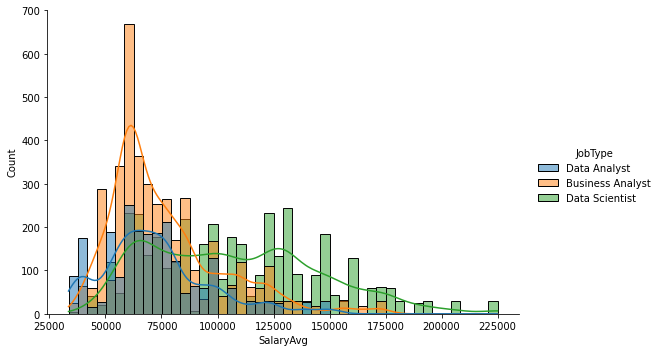

In [ ]:
# looking at the salary distribution of each job type
salary_plot = sns.displot(x='SalaryAvg', data=data, hue='JobType', kde=True, aspect=1.5)

# saving the figure
salary_fig = salary_plot.fig
salary_fig.savefig(output_path + 'salary_hist_kf.png') 

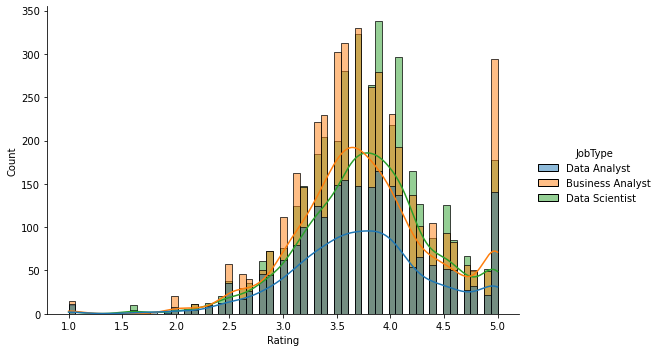

In [ ]:
# plotting the distribution of rating 
rating_plot = sns.displot(x='Rating', data=data, hue='JobType', kde=True, aspect=1.5)

# saving the figure
rating_fig = rating_plot.fig
rating_fig.savefig(output_path + 'rating_hist_kf.png') 

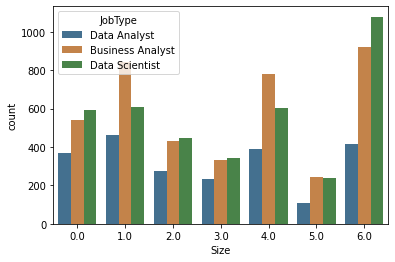

In [ ]:
# plotting the rating distribution
size_plot = sns.countplot(x='Size', hue='JobType', saturation=0.5, data=data)

# saving the figure
size_fig = size_plot.get_figure()
size_fig.savefig(output_path + 'size_bar_kf.png') 

In [ ]:
# taking a look at the correlations between certain features
data[['Rating', 'SalaryAvg', 'OrganizationAge', 'Size', 'JobType']].replace({'JobType': {'Data Analyst': 0, 'Business Analyst': 1, 'Data Scientist': 2}}).corr()

Rating  SalaryAvg  OrganizationAge      Size   JobType
Rating           1.000000   0.059236        -0.114179 -0.192062  0.028877
SalaryAvg        0.059236   1.000000        -0.034585  0.014194  0.426619
OrganizationAge -0.114179  -0.034585         1.000000  0.318945  0.027096
Size            -0.192062   0.014194         0.318945  1.000000  0.071762
JobType          0.028877   0.426619         0.027096  0.071762  1.000000

## Job Description - Word Clouds

### Data Scientist

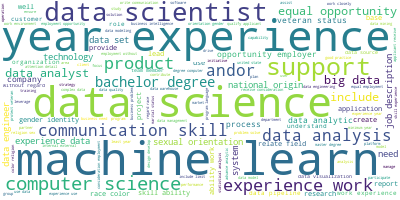

In [ ]:
# creating data scientist mask
ds_mask = data['JobType'] == 'Data Scientist'

# Join the different lemmas together
ds_lemmas = " ".join(list(processed_text[ds_mask]['JobDescription_lemmas'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color = "white", 
                      max_words = 5000, 
                      contour_width = 3, 
                      contour_color = 'steelblue')

# Generate a word cloud
wordcloud.generate(ds_lemmas)

# Save the word cloud
wordcloud.to_file(output_path + "/ds_wordcloud.png")

# Visualize the word cloud
wordcloud.to_image()

### Data Analyst

In [ ]:
# remove the rows that have NA as JobDescription 
processed_text['JobType'] = data['JobType']
processed_text.drop(processed_text[processed_text['JobDescription_lemmas'].isna()].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


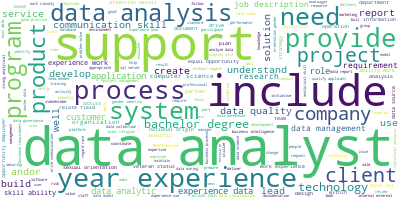

In [ ]:
# creating data analyst mask
da_mask = data['JobType'] == 'Data Analyst'

# Join the different lemmas together
da_lemmas = " ".join(list(processed_text[da_mask]['JobDescription_lemmas'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color = "white", 
                      max_words = 5000, 
                      contour_width = 3, 
                      contour_color = 'steelblue')

# Generate a word cloud
wordcloud.generate(da_lemmas)

# Save the word cloud
wordcloud.to_file(output_path + "/da_wordcloud.png")

# Visualize the word cloud
wordcloud.to_image()

### Business Analyst

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


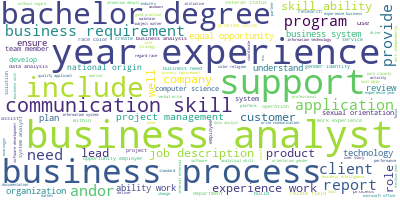

In [ ]:
# creating data analyst mask
ba_mask = data['JobType'] == 'Business Analyst'

# Join the different lemmas together
ba_lemmas = " ".join(list(processed_text[ba_mask]['JobDescription_lemmas'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color = "white", 
                      max_words = 5000, 
                      contour_width = 3, 
                      contour_color = 'steelblue')

# Generate a word cloud
wordcloud.generate(ba_lemmas)

# Save the word cloud
wordcloud.to_file(output_path + "/ba_wordcloud.png")

# Visualize the word cloud
wordcloud.to_image()

## Job Description - Clustering

In [ ]:
#NMF: Making a UDF to run NMF
def nmf_function(num_components, doc_text_matrix, vectorizer):
    nmf = NMF(num_components)
    doc_topic = nmf.fit_transform(doc_text_matrix)
    
    index = []
    for i in range(num_components):
        index.append(i)
    topic_word = pd.DataFrame(nmf.components_.round(3),
             index = index,
             columns = vectorizer.get_feature_names())
    
    print(display_topics(nmf, vectorizer.get_feature_names(), 15))

In [ ]:
#Running tfidf on job descriptions
stop_words = text.ENGLISH_STOP_WORDS
cv_tfidf = TfidfVectorizer(stop_words=stop_words, min_df=0.1, max_df=0.7)
x_tfidf = cv_tfidf.fit_transform(data.JobDescription).toarray()
df_tfidf = pd.DataFrame(x_tfidf,columns=cv_tfidf.get_feature_names())

In [ ]:
job_titles = data['JobType'].values

In [ ]:
#run NMF on output of TFIDF

def nmf_HMatrix(num_components, doc_text_matrix, vectorizer):
    nmf = NMF(num_components)
    doc_topic = nmf.fit_transform(doc_text_matrix)
    
    idx = []
    for i in range(num_components):
        idx.append(i) 
    H = pd.DataFrame(doc_topic.round(3),
                    index = job_titles,
                    columns = idx)
    return H

In [ ]:
h9 = nmf_HMatrix(9,df_tfidf,cv_tfidf)
h9

0      1      2      3      4      5      6      7      8
Data Analyst    0.021  0.005  0.060  0.032  0.045  0.017  0.013  0.007  0.039
Data Analyst    0.015  0.000  0.000  0.085  0.070  0.000  0.000  0.000  0.056
Data Analyst    0.113  0.023  0.045  0.008  0.000  0.006  0.000  0.000  0.000
Data Analyst    0.027  0.007  0.075  0.017  0.025  0.066  0.014  0.016  0.010
Data Analyst    0.038  0.001  0.009  0.037  0.026  0.049  0.000  0.000  0.009
...               ...    ...    ...    ...    ...    ...    ...    ...    ...
Data Scientist  0.000  0.006  0.000  0.017  0.000  0.074  0.046  0.000  0.011
Data Scientist  0.000  0.000  0.000  0.274  0.000  0.000  0.000  0.000  0.000
Data Scientist  0.009  0.042  0.062  0.038  0.045  0.016  0.014  0.026  0.000
Data Scientist  0.012  0.047  0.006  0.040  0.053  0.010  0.006  0.029  0.000
Data Scientist  0.011  0.007  0.008  0.000  0.038  0.053  0.000  0.000  0.018

[10254 rows x 9 columns]

In [ ]:
X=x_tfidf
model=NMF(9)
model.fit(X)
nmf_features = model.transform(X)


components_df = pd.DataFrame(model.components_, columns=cv_tfidf.get_feature_names())


In [ ]:
#get top words per topic from output of NMF
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
analytics     1.779665
insights      1.336162
marketing     1.220417
product       1.210290
team          0.830513
dashboards    0.659290
tableau       0.658031
drive         0.654642
key           0.649382
analysis      0.639048
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
learning       1.867747
machine        1.628548
science        0.942588
models         0.817931
python         0.588413
scientist      0.523251
research       0.431293
engineering    0.430432
deep           0.414148
modeling       0.408016
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
status        1.417434
employment    1.130901
gender        0.915227
protected     0.873540
disability    0.784341
applicants    0.758678
equal         0.747177
veteran       0.708243
national      0.706999
race          0.704608
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
databases      1.06928

### K-Means

In [ ]:
#running kmean clustering on output of NMF
kmeans9 = KMeans(n_clusters=3,random_state=555)
clustering_ori9 = kmeans9.fit_predict(h9)
kmeans9.cluster_centers_


array([[0.01962856, 0.01017603, 0.06681052, 0.01309059, 0.02786986,
        0.02646282, 0.01541258, 0.0208129 , 0.02192761],
       [0.01863507, 0.00747332, 0.004708  , 0.02056734, 0.03033206,
        0.0189335 , 0.02753325, 0.02881578, 0.01684467],
       [0.0204135 , 0.10233755, 0.01574177, 0.01393333, 0.00688354,
        0.02408186, 0.01092911, 0.00828861, 0.01434177]])

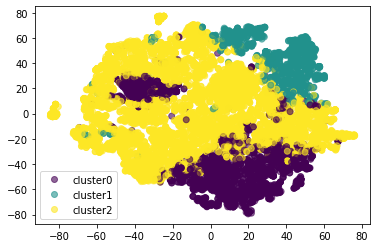

In [ ]:
#TSNE on kmeans of NMF output
labels= kmeans9.predict(h9)

label=["cluster0", "cluster1", "cluster2"]

model=TSNE(learning_rate=100)
Tsne_transformed=model.fit_transform(h9)


xs =Tsne_transformed[:,0]
ys=Tsne_transformed[:,1]
scatter=plt.scatter(xs,ys, c=labels, alpha=.6)

handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, label)




In [ ]:
#comparing outputs of kmeans clusters (on output of NMF on TFIDF) to actual job descriptions

cluster_comparison = pd.DataFrame(kmeans9.predict(h9), job_titles)
cluster_comparison["cluster"]=cluster_comparison[0]
cluster_comparison = cluster_comparison.drop(0, axis=1)
cluster_comparison.reset_index(inplace=True)
cluster_comparison.groupby(['index', 'cluster']).size()

index             cluster
Business Analyst  0          1874
                  1            18
                  2          2200
Data Analyst      0           316
                  1            80
                  2          1857
Data Scientist    0           326
                  1          1162
                  2          2421
dtype: int64

Hierarchical Clustering

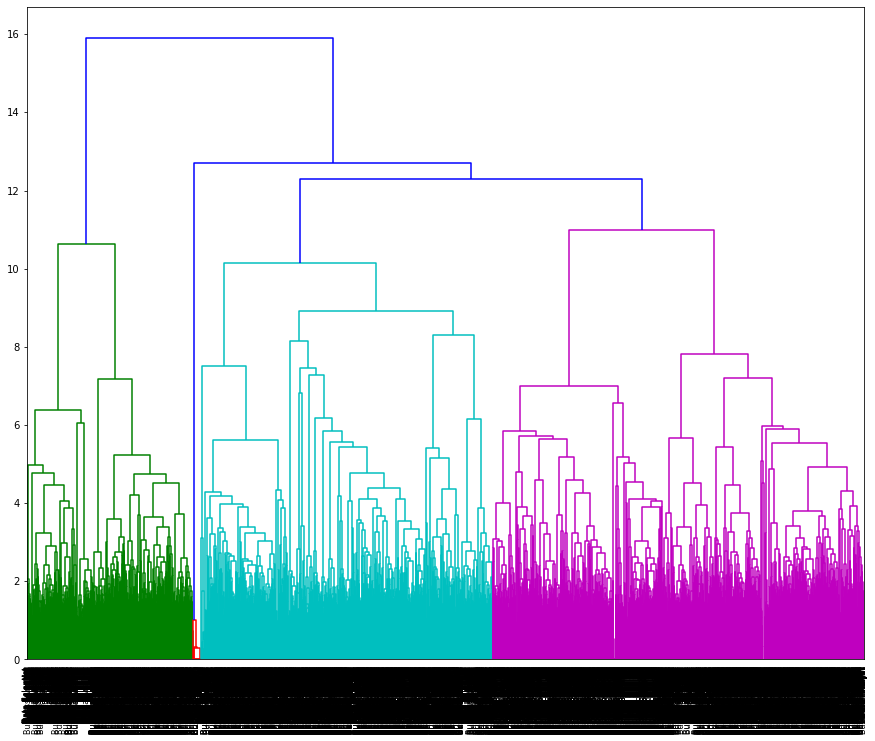

In [ ]:
#hierarchical clustering on output of TFIDF only


labels=list(job_titles)



x = df_tfidf.values
normalized_x = normalize(x)
plt.figure(figsize=(15,12))

mergings = linkage(normalized_x, method='ward')

dendrogram(mergings,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8
)



plt.show()

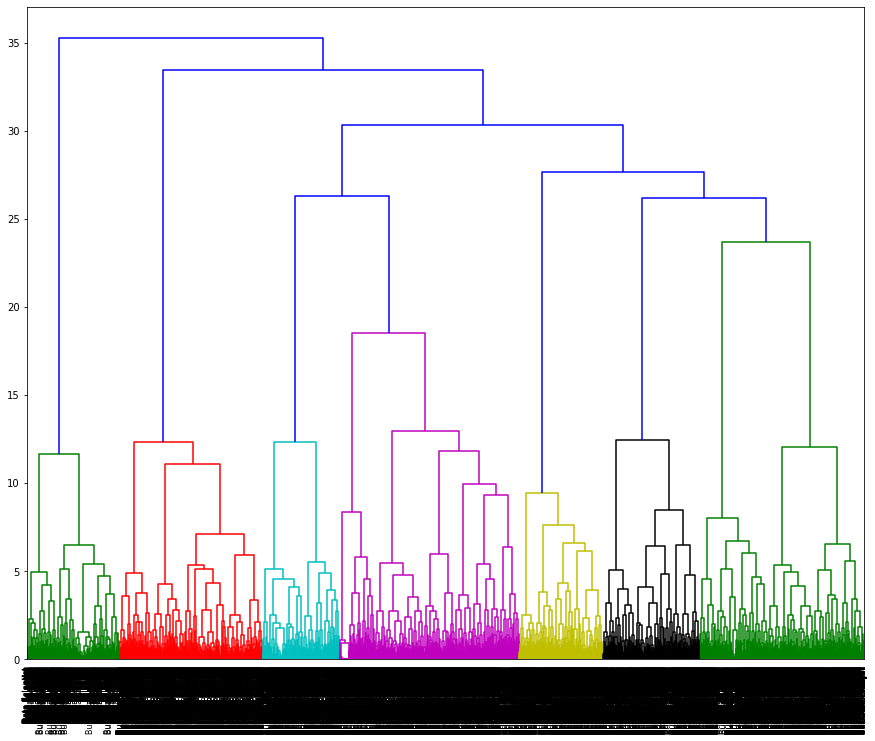

In [ ]:
#heirarchical clustering on output of NMF on TFIDF



labels=list(job_titles)



x=h9.values
normalized_x = normalize(x)
plt.figure(figsize=(15,12))

mergings = linkage(normalized_x, method='ward')

dendrogram(mergings,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8
)



plt.show()

## Job Description - t-SNE Visualization

In [ ]:
# downloading stop words from nltk package
stop_words = stopwords.words('english')

# to account for misspelling of conjunctions, we are adding conjunctions
# without the apostrophes
stop_words_mispelled = [word.replace("'", '') for word in stop_words]
stop_words = list(set(stop_words + stop_words_mispelled))

In [ ]:
# creating corpus using job descriptions with some minor text cleanup
corpus = data['JobDescription'].str.lower().str.replace('[-,;\.:]', '', regex=True)

# creating tfidf vector object to create a feature space
# token pattern is custom to allow single-word tokens
tfidf_obj = TfidfVectorizer(token_pattern=r'(?u)\b[a-z]+\b', stop_words=stop_words)

# creating truncated svd object to reduce the feature space
# using 100 dimensions according to documentation
svd_obj = TruncatedSVD(n_components=100)

# creating vectorization of corpus
tfidf_corpus = tfidf_obj.fit_transform(corpus)

# reducing dimensions
tfidf_corpus_red = svd_obj.fit_transform(tfidf_corpus)

In [ ]:
# creating a list of three job types
# will be used to add poinst to plots one type at a time
job_types = data['JobType'].unique()

# the figure will have n_rows * n_cols number of subplots
n_rows = 3
n_cols = 2

# instantiated a figure object
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

# initializing perplexity at 0 and will incrementally increase for each subplot
# learn rate was chosen to be 200 after several attempts at other learning rates
perplexity = 0
learn_rate = 200

# plotting the data for one subplot at a time
for row in range(n_rows):
    for col in range(n_cols):

        # running tsne on the data with the current loop perplexity
        perplexity += 10
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learn_rate)
        tsne_reduced = tsne.fit_transform(tfidf_corpus_red)

        # adding points for one job type at at time
        for j_type in job_types:
            job_mask = data['JobType'] == j_type
            axs[row, col].scatter(tsne_reduced[job_mask, 0],
                                  tsne_reduced[job_mask, 1],
                                  label=j_type,
                                  alpha=0.30,
                                  edgecolors='#000000',
                                  s=40)
            
        # adding axis labels
        axs[row, col].set_title(f'Perplexity = {perplexity}', size=16, weight='bold')
        axs[row, col].set_xlabel('Component 1', size=14, weight='bold')
        axs[row, col].set_ylabel('Component 2', size=14, weight='bold')

        # adding legend
        axs[row, col].legend(loc='lower right')
    
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig.savefig(output_path + f'tsne_learning_rate_{learn_rate}.png', facecolor='white', transparent=False)

# Modeling

## Unsupervised

### Topic Modeling

#### Latent Dirichlet Allocation (LDA)



##### Job Descriptions

In [ ]:
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')
tfidf_fit = tfidf.fit_transform(data['JobDescription'])

In [ ]:
# generate 3 topic
lda = LatentDirichletAllocation(n_components=3,random_state=42)
lda_fit  = lda.fit(tfidf_fit)

# extracting the keywordss in each topic 
for id_value, value in enumerate(lda_fit.components_):
   print(f"The topic would be {id_value}") 
   print([tfidf.get_feature_names()[index] for index in value.argsort()[-10:]])
   print("\n")


The topic would be 0
['epiq', 'macquarie', 'cgi', 'qiskit', 'humana', 'guidehouse', 'gs', 'band', 'capgemini', 'quantum']


The topic would be 1
['systems', 'analysis', 'analyst', 'ability', 'skills', 'work', 'management', 'requirements', 'business', 'data']


The topic would be 2
['insights', 'work', 'python', 'science', 'team', 'business', 'machine', 'analytics', 'learning', 'data']




##### Data Scientist

In [ ]:
ds_lda = data[data['JobType']=='Data Scientist']['JobDescription']

In [ ]:
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')
ds_tfidf_fit = tfidf.fit_transform(ds_lda)

In [ ]:
# generate 3 topic
lda = LatentDirichletAllocation(n_components=3,random_state=42)
ds_lda_fit  = lda.fit(ds_tfidf_fit)

# extracting the keywordss in each topic 
for id_value, value in enumerate(ds_lda_fit.components_):
   print(f"The topic would be {id_value}") 
   print([tfidf.get_feature_names()[index] for index in value.argsort()[-10:]])
   print("\n")

The topic would be 0
['lab', 'drug', 'clinical', 'scientific', 'assays', 'chemistry', 'molecular', 'biology', 'laboratory', 'cell']


The topic would be 1
['years', 'development', 'analysis', 'science', 'analytics', 'learning', 'skills', 'team', 'work', 'business']


The topic would be 2
['tutor', 'tetra', 'band', 'middot', 'varsity', 'accenture', 'tutoring', 'gs', 'gsk', 'tutors']




##### Data Analyst

In [ ]:
da_lda = data[data['JobType']=='Data Analyst']['JobDescription']

In [ ]:
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')
da_tfidf_fit = tfidf.fit_transform(da_lda)

In [ ]:
# generate 3 topic
lda = LatentDirichletAllocation(n_components=3,random_state=42)
da_lda_fit  = lda.fit(da_tfidf_fit)

# extracting the keywordss in each topic 
for id_value, value in enumerate(da_lda_fit.components_):
   print(f"The topic would be {id_value}") 
   print([tfidf.get_feature_names()[index] for index in value.argsort()[-10:]])
   print("\n")

The topic would be 0
['hcc', 'guidewire', 'lowes', 'caregivers', 'clinicians', 'middot', 'half', 'mount', 'sinai', 'robert']


The topic would be 1
['registrar', 'analystengineer', 'etlelt', 'greetings', 'âwww', 'tumor', 'temple', 'conch', 'conchtech', 'bull']


The topic would be 2
['analytics', 'knowledge', 'analyst', 'team', 'ability', 'management', 'analysis', 'skills', 'work', 'business']




##### Business Analyst

In [ ]:
ba_lda = data[data['JobType']=='Business Analyst']['JobDescription']

In [ ]:
tfidf = TfidfVectorizer(max_df=0.9,min_df=2,stop_words='english')
ba_tfidf_fit = tfidf.fit_transform(ba_lda)

In [ ]:
# generate 3 topic
lda = LatentDirichletAllocation(n_components=3,random_state=42)
ba_lda_fit  = lda.fit(ba_tfidf_fit)

# extracting the keywordss in each topic 
for id_value, value in enumerate(ba_lda_fit.components_):
   print(f"The topic would be {id_value}") 
   print([tfidf.get_feature_names()[index] for index in value.argsort()[-10:]])
   print("\n")

The topic would be 0
['analysis', 'team', 'systems', 'project', 'ability', 'management', 'skills', 'work', 'requirements', 'data']


The topic would be 1
['font', 'arthur', 'lawrence', 'labeling', 'aston', 'carter', 'mso', 'harris', 'band', 'gs']


The topic would be 2
['fargo', '22nd', 'wells', 'virginia', 'cabinet', 'civilian', 'threat', 'leidos', 'usaa', 'accenture']




#### Top2Vec

##### Job Descriptions

In [ ]:
# parsing raw JobDescription text
docs_raw = list(data['JobDescription'].values)
docs_raw[:5]

["Are you eager to roll up your sleeves and harness data to drive policy change? Do you enjoy sifting through complex datasets to illuminate trends and insights? Do you see yourself working for a values-driven organization with a vision to tackle the most pressing injustices of our day?  We are looking to hire a bright, hard-working, and creative individual with strong data management skills and a demonstrated commitment to immigrant's rights. The Data Analyst will assist with analysis and reporting needs for Veras Center on Immigration and Justice (CIJ), working across its current projects and future Vera initiatives.  Who we are:  Founded in 1961, The Vera Institute is an independent, non-partisan, nonprofit organization that combines expertise in research, technical assistance, and demonstration projects to assist leaders in government and civil society examine justice policy and practice, and improve the systems people rely on for justice and safety. We study problems that impede h

In [ ]:
# fitting the Top2Vec model using USE embeddings on the raw job description text
# top2vec_raw = Top2Vec(docs_raw, 
#                       speed = 'deep-learn', 
#                       embedding_model = 'universal-sentence-encoder')

# saving raw Top2Vec model
# top2vec_raw.save(root_path + "/data/top2vec_raw")

2021-03-14 20:40:50,740 - top2vec - INFO - Pre-processing documents for training
2021-03-14 20:41:07,828 - top2vec - INFO - Downloading universal-sentence-encoder model
2021-03-14 20:41:25,304 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-14 20:41:56,011 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-14 20:42:33,999 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-14 20:42:34,505 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# loading raw Top2Vec model
top2vec_raw = Top2Vec.load(root_path + "/data/top2vec_raw")

In [ ]:
# getting number of topics
top2vec_raw.get_num_topics()

48

In [ ]:
# getting top 3 topics
topic_words_raw, word_scores_raw, topic_nums_raw = top2vec_raw.get_topics(3)

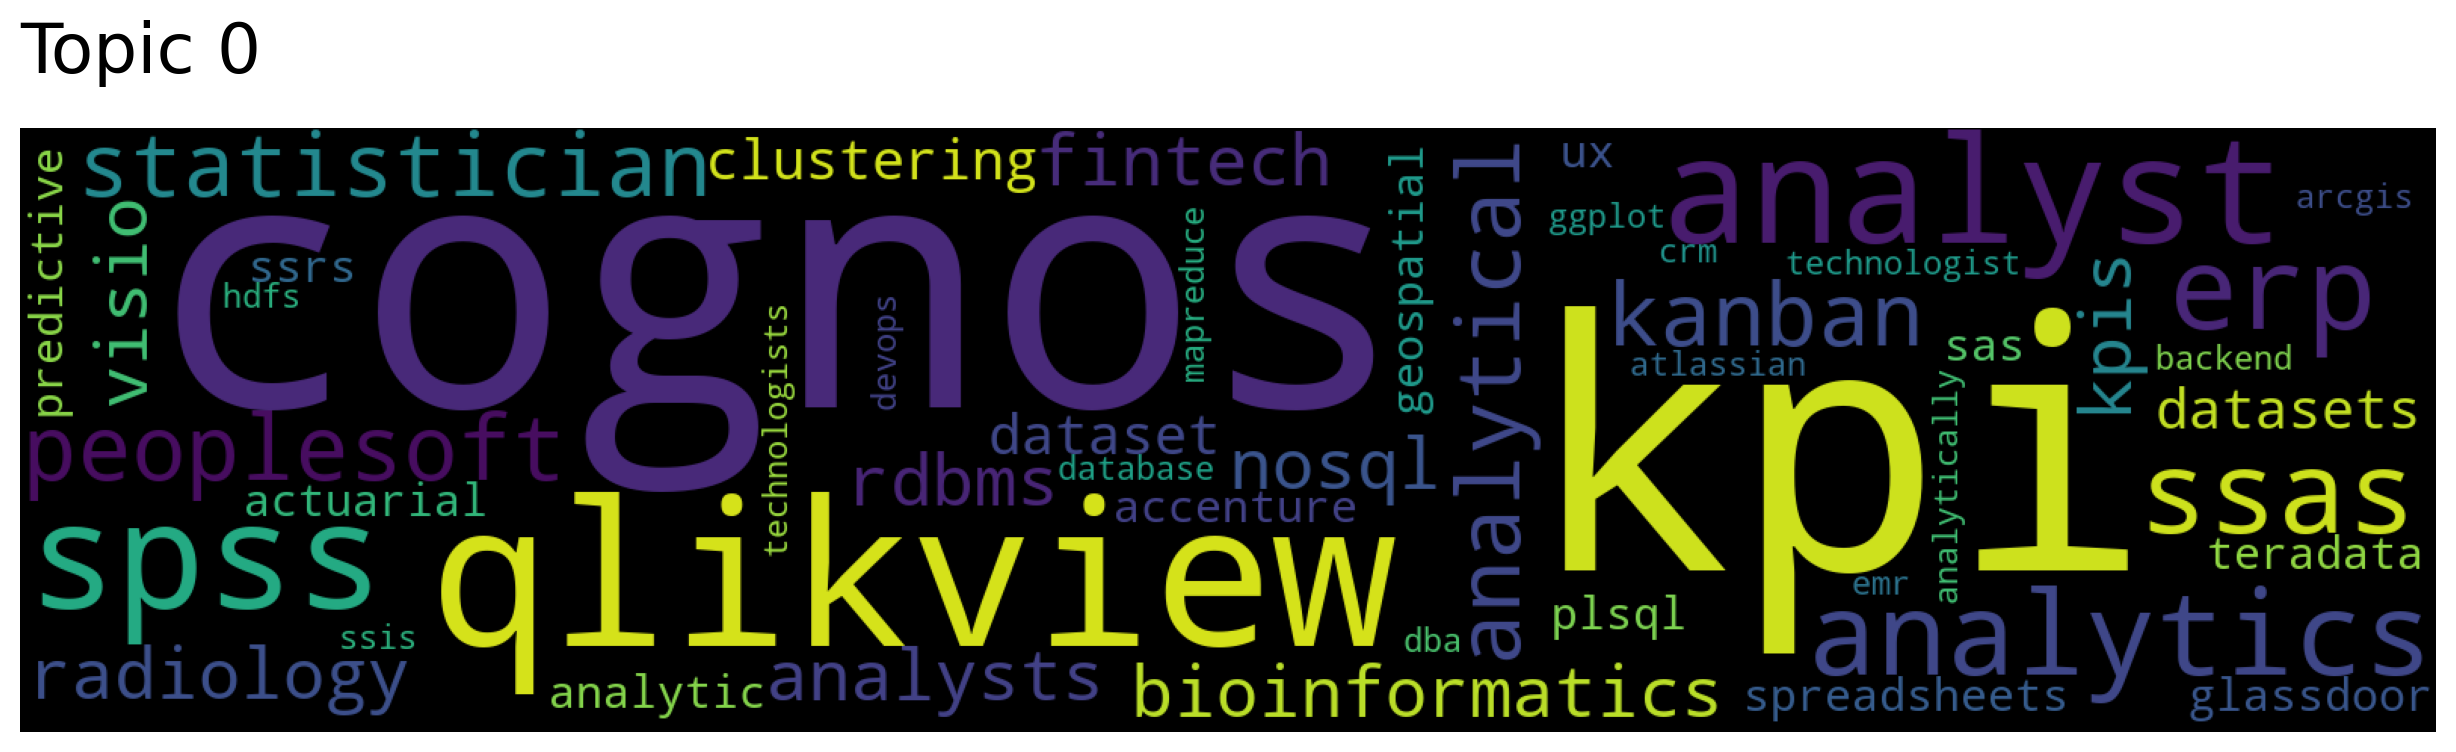

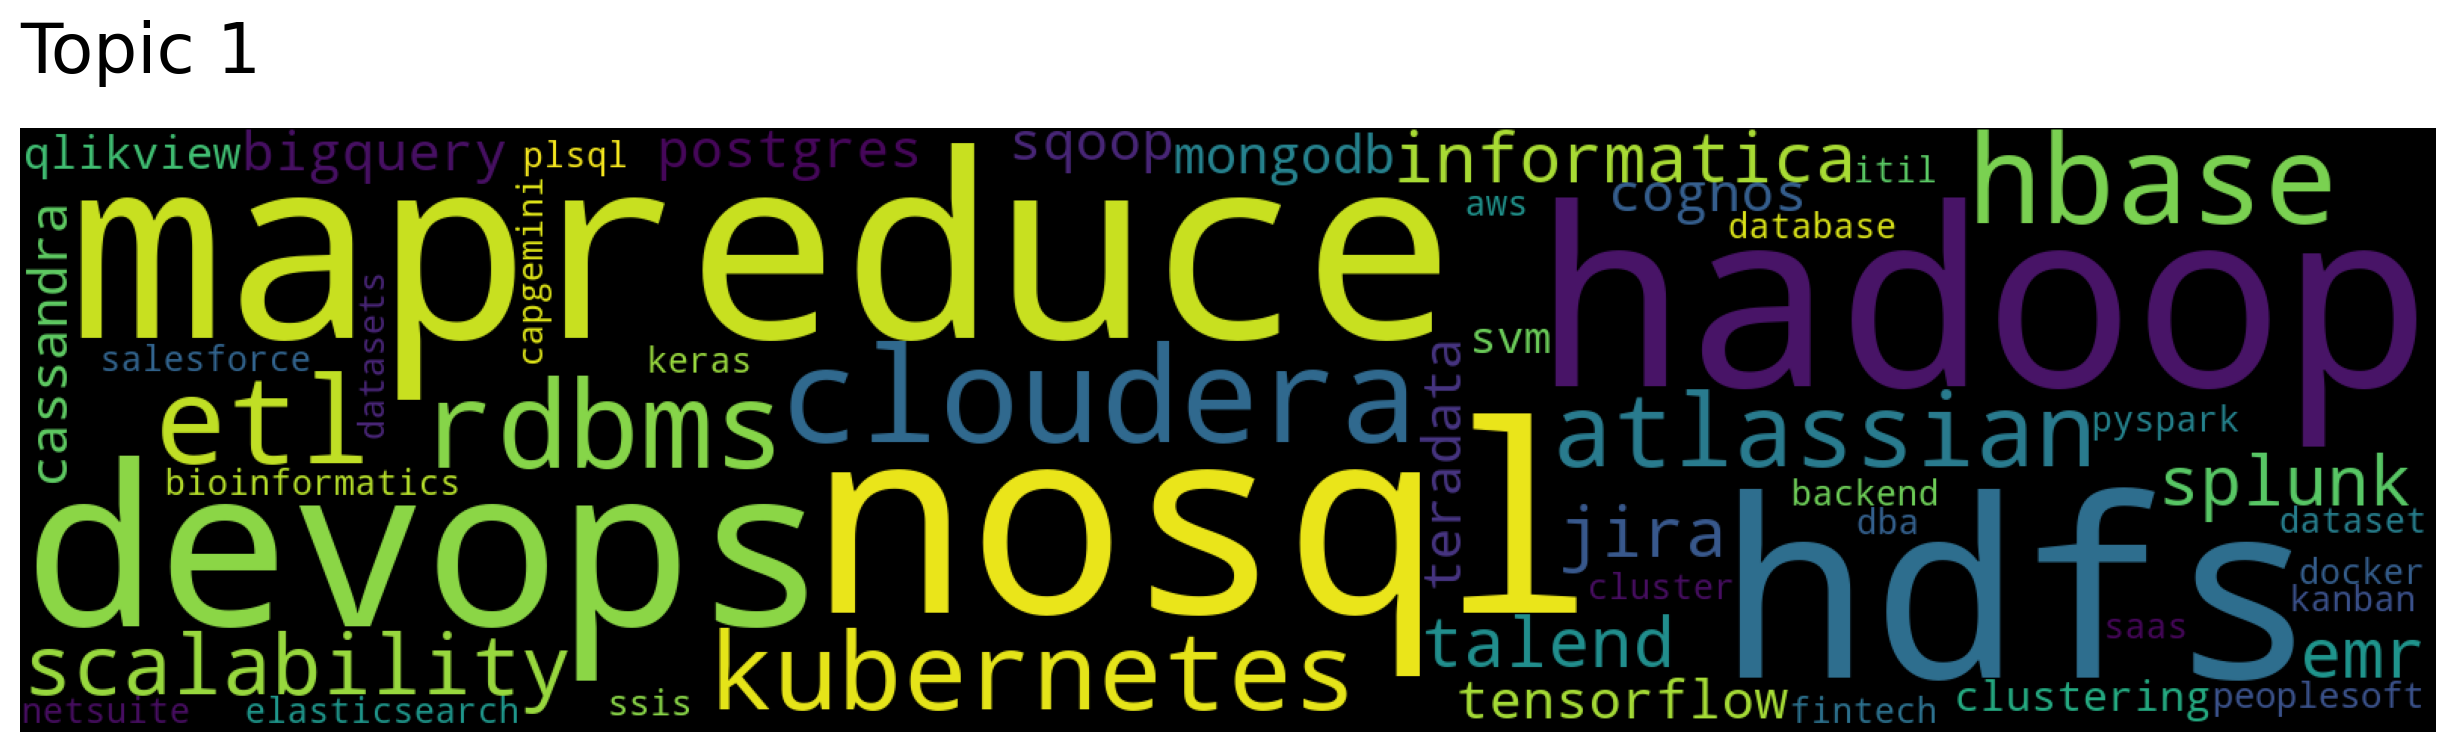

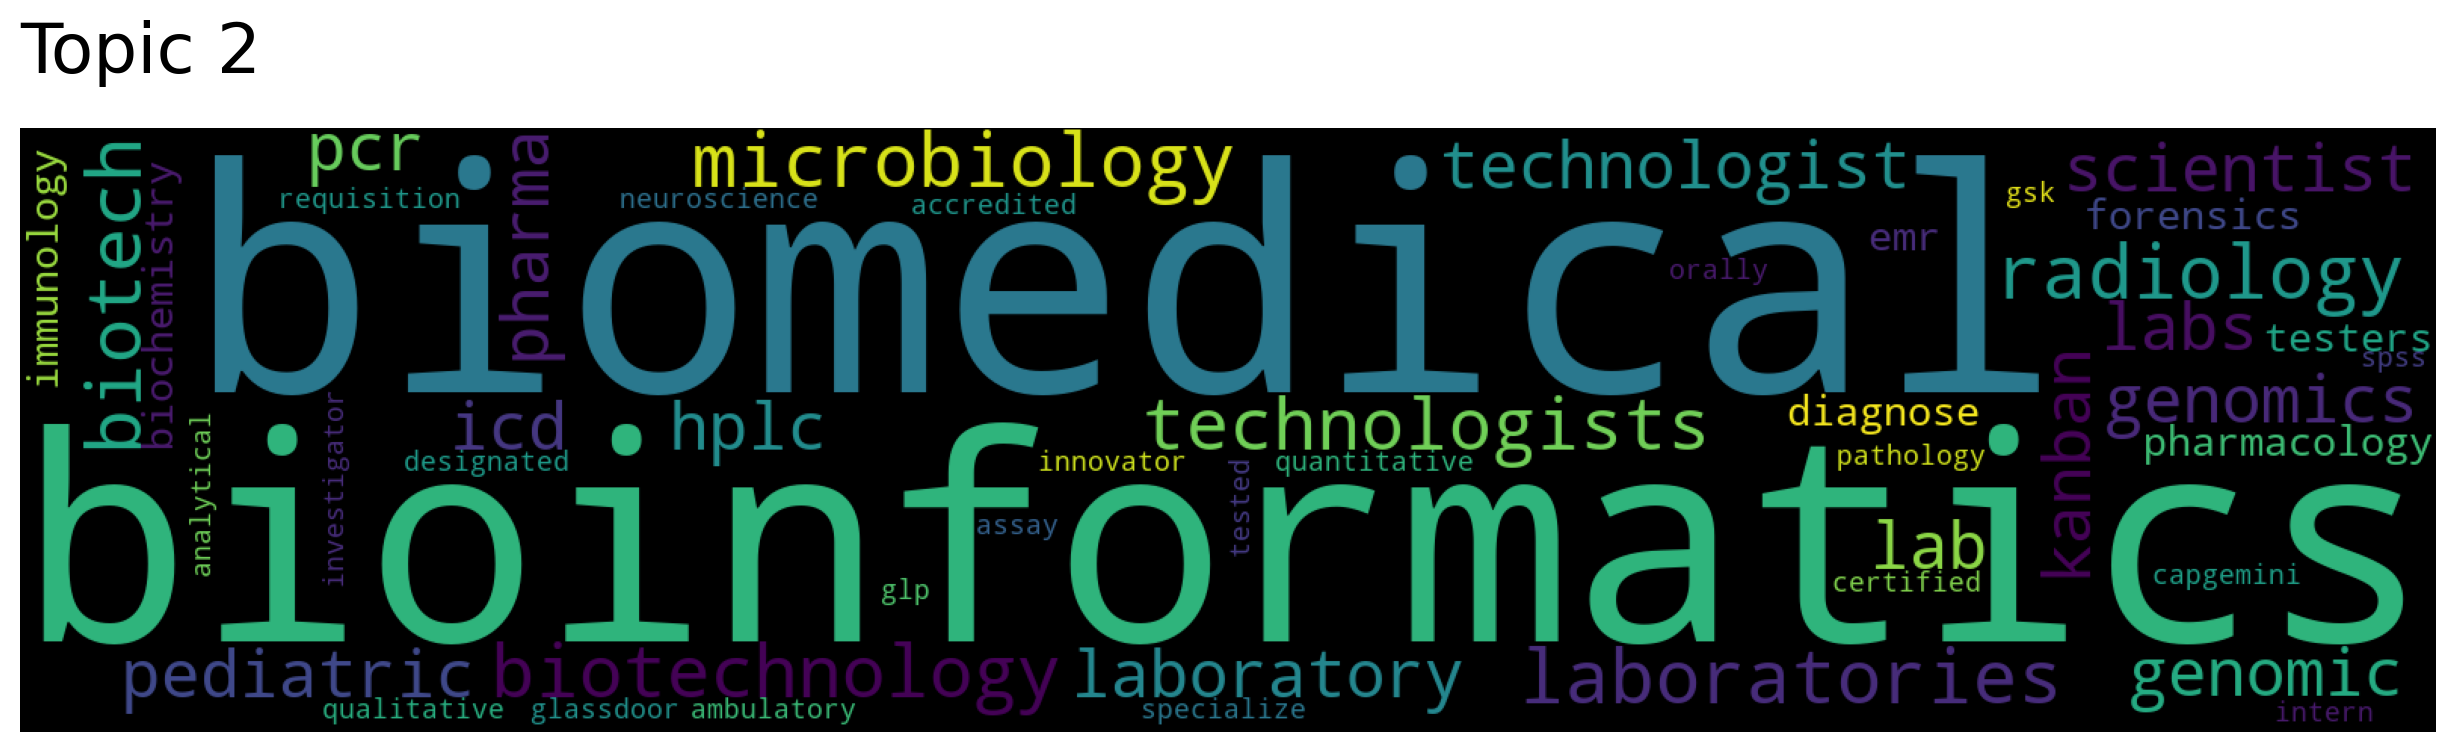

In [ ]:
# plotting word clouds for the top 5 topics
for topic in topic_nums_raw:
  top2vec_raw.generate_topic_wordcloud(topic)

##### Data Scientist

In [ ]:
# parsing raw data scientist text
ds_raw = list(data[data['JobType'] == 'Data Scientist']['JobDescription'].values)
ds_raw[:5]

['ABOUT HOPPER  At Hopper, we’re on a mission to make booking travel faster, easier, and more transparent. We are leveraging the power that comes from combining massive amounts of data and machine learning to build the world’s fastest-growing travel app -- one that enables our customers to save money and travel more. With over $235M CAD in funding from leading investors in both Canada and the US, Hopper is primed to continue its path toward becoming the go-to way to book travel as the world continues its shift to mobile.  Recognized as the fastest-growing travel app by Forbes and one of the world’s most innovative companies by Fast Company two years in a row, Hopper has been downloaded over 40 million times and has helped travelers plan over 100 million trips and counting. The app has received high praise in the form of mobile accolades such as the Webby Award for Best Travel App of 2019, the Google Play Award for Standout Startup of 2016 and Apple’s App Store Best of 2015.  Take off w

In [ ]:
# fitting the Top2Vec model using USE embeddings on the raw data scientist text
# top2vec_ds_raw = Top2Vec(ds_raw, 
#                          speed = 'deep-learn', 
#                          embedding_model = 'universal-sentence-encoder')

# saving raw Top2Vec model
# top2vec_ds_raw.save(root_path + "/data/top2vec_ds_raw")

2021-03-14 20:49:05,511 - top2vec - INFO - Pre-processing documents for training
2021-03-14 20:49:12,489 - top2vec - INFO - Downloading universal-sentence-encoder model
2021-03-14 20:49:30,376 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-14 20:49:42,537 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-14 20:50:18,319 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-14 20:50:18,477 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# loading raw Top2Vec model
top2vec_ds_raw = Top2Vec.load(root_path + "/data/top2vec_ds_raw")

In [ ]:
# getting number of topics
top2vec_ds_raw.get_num_topics()

14

In [ ]:
# getting top 5 topics
topic_words_ds_raw, word_scores_ds_raw, topic_nums_ds_raw = top2vec_ds_raw.get_topics(3)

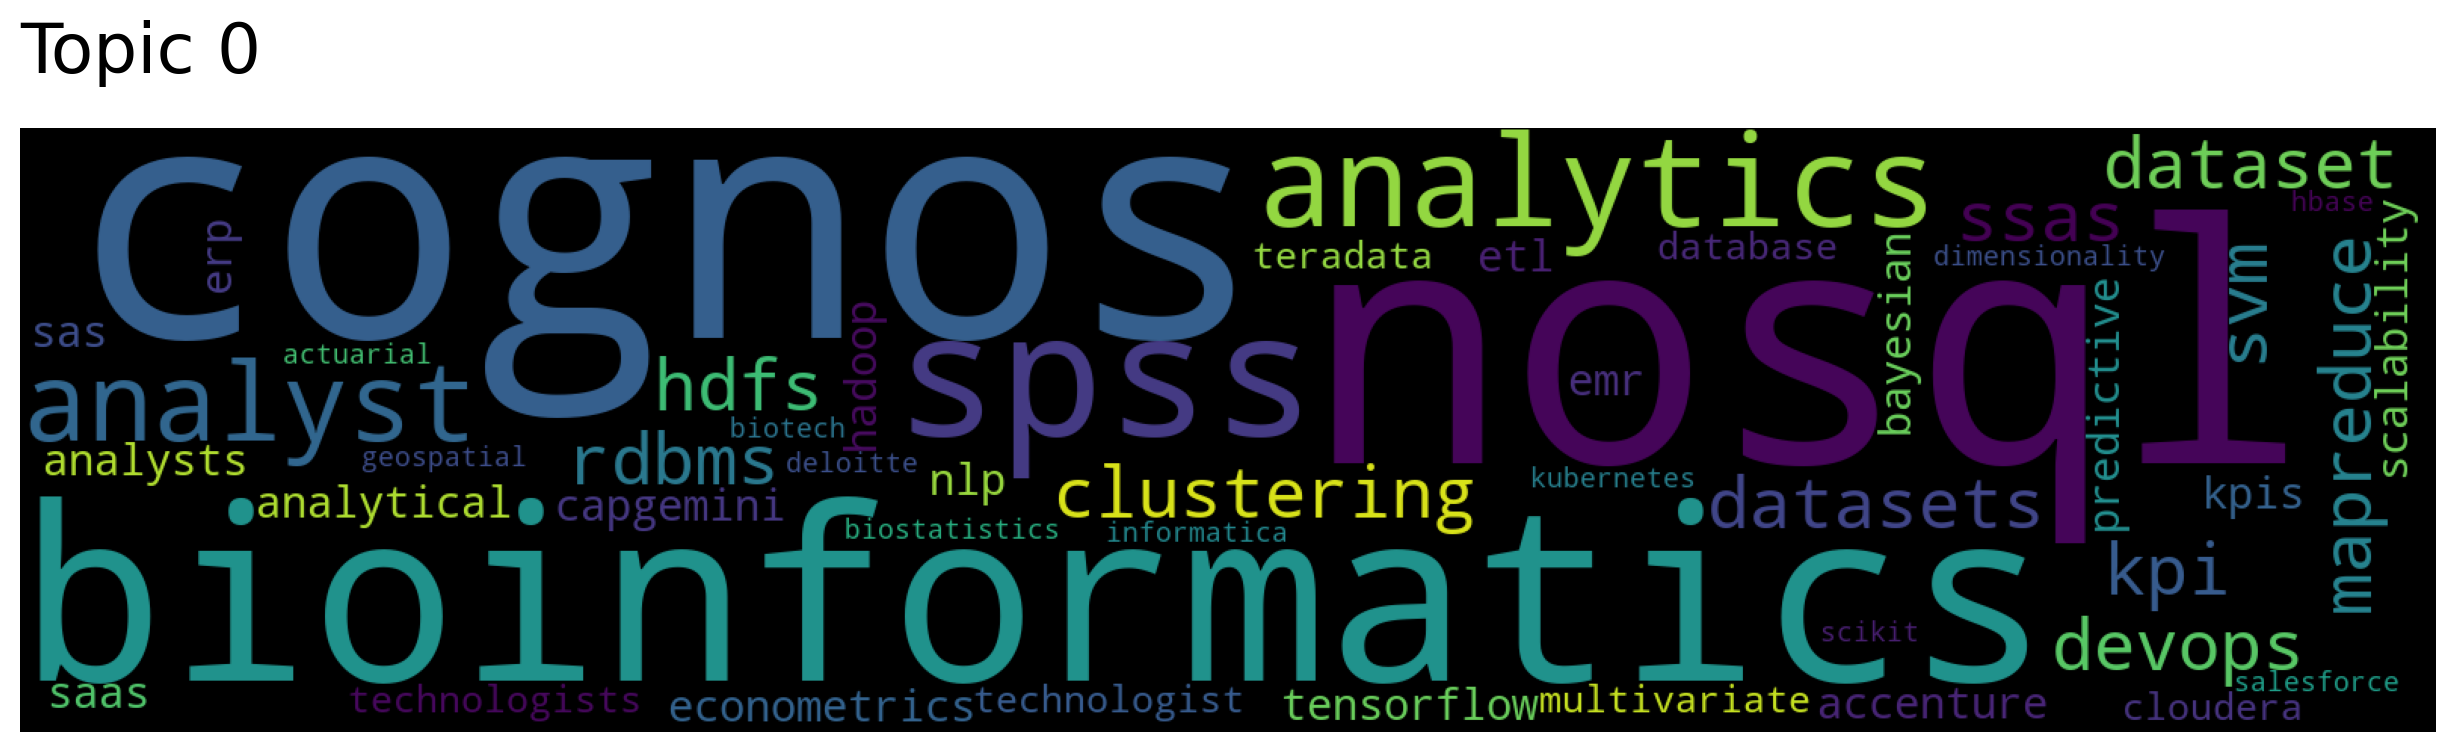

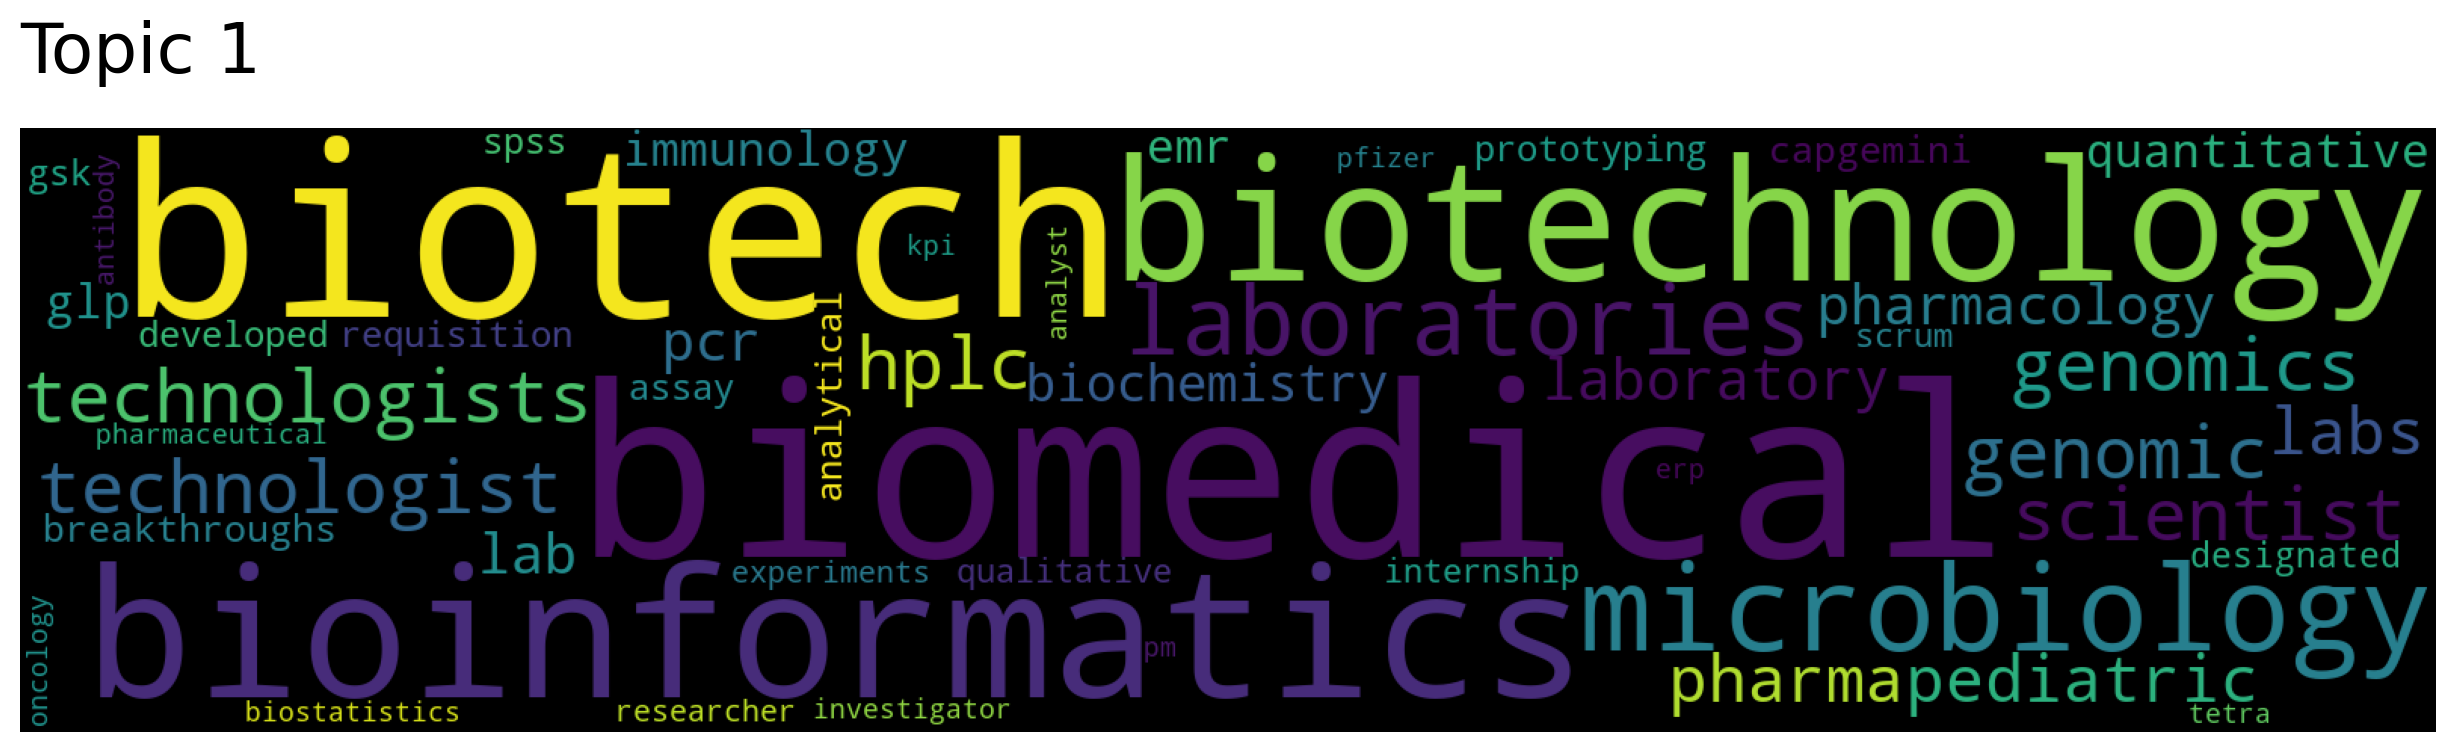

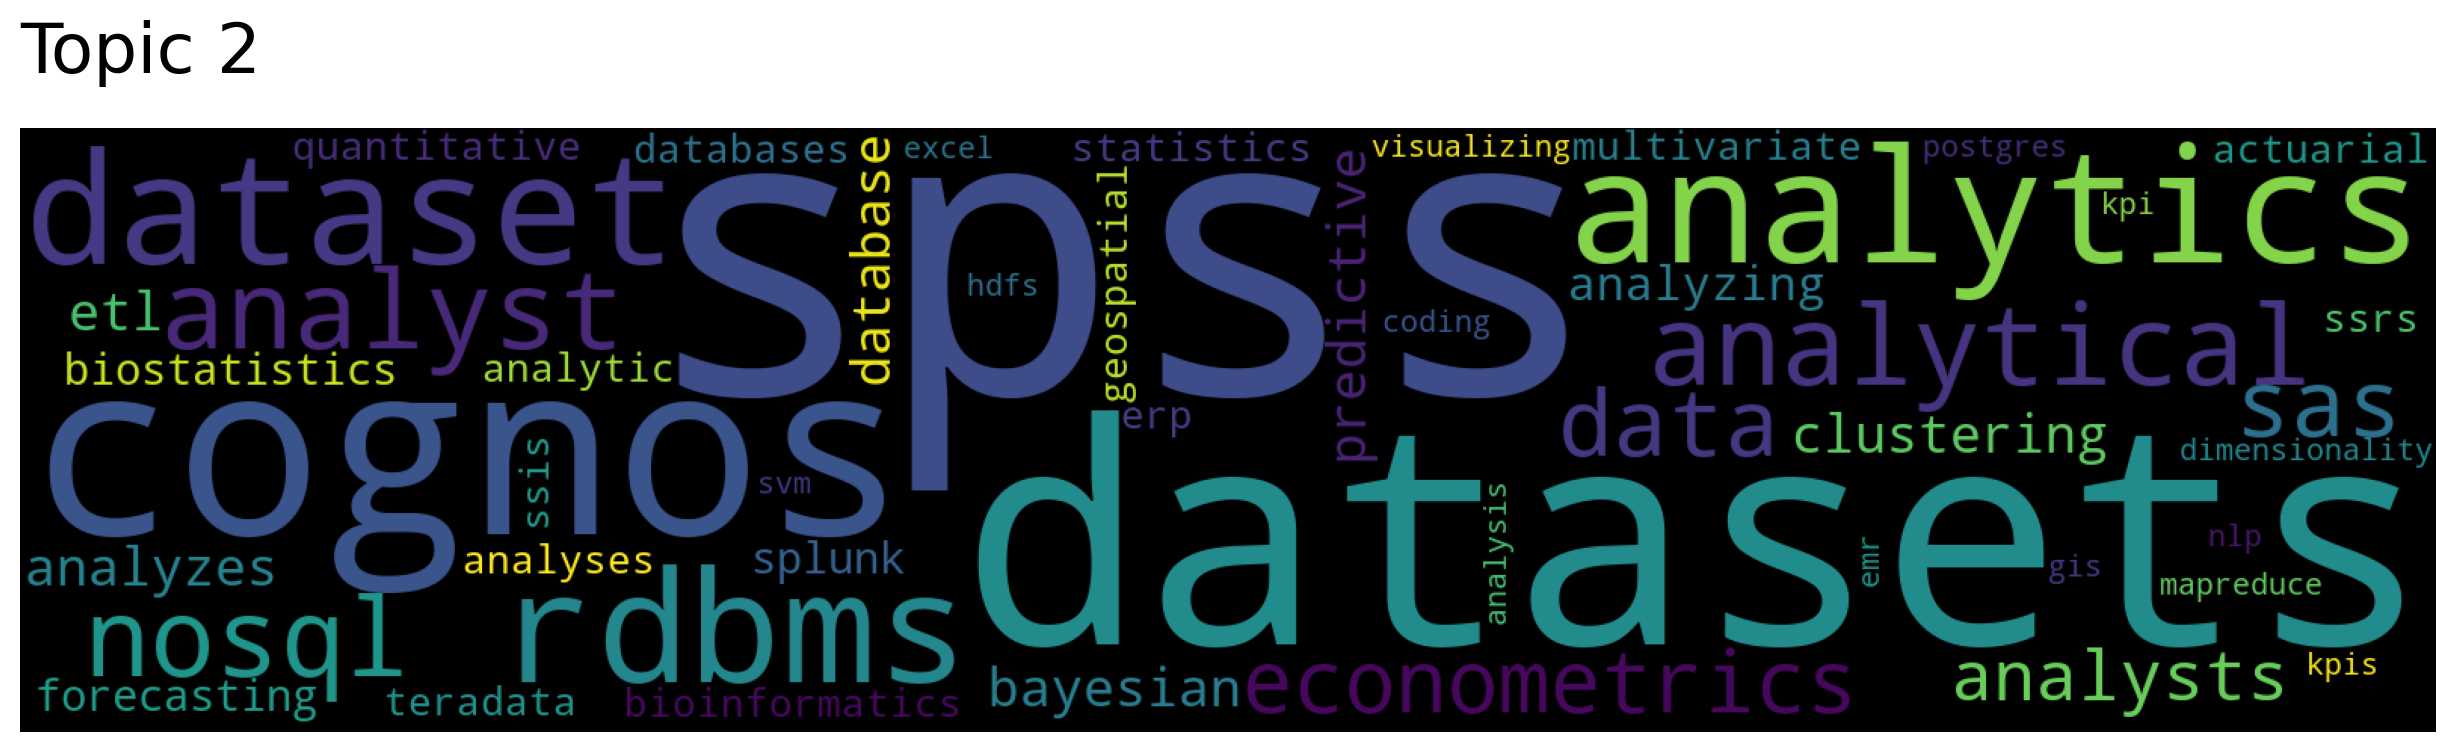

In [ ]:
# plotting word clouds for the top 3 topics
for topic in topic_nums_ds_raw:
  top2vec_ds_raw.generate_topic_wordcloud(topic)

##### Data Analyst

In [ ]:
# parsing raw data analyst text
da_raw = list(data[data['JobType'] == 'Data Analyst']['JobDescription'].values)
da_raw[:5]

["Are you eager to roll up your sleeves and harness data to drive policy change? Do you enjoy sifting through complex datasets to illuminate trends and insights? Do you see yourself working for a values-driven organization with a vision to tackle the most pressing injustices of our day?  We are looking to hire a bright, hard-working, and creative individual with strong data management skills and a demonstrated commitment to immigrant's rights. The Data Analyst will assist with analysis and reporting needs for Veras Center on Immigration and Justice (CIJ), working across its current projects and future Vera initiatives.  Who we are:  Founded in 1961, The Vera Institute is an independent, non-partisan, nonprofit organization that combines expertise in research, technical assistance, and demonstration projects to assist leaders in government and civil society examine justice policy and practice, and improve the systems people rely on for justice and safety. We study problems that impede h

In [ ]:
# fitting the Top2Vec model using USE embeddings on the raw data analyst text
# top2vec_da_raw = Top2Vec(da_raw, 
#                          speed = 'deep-learn', 
#                          embedding_model = 'universal-sentence-encoder')

# saving raw Top2Vec model
# top2vec_da_raw.save(root_path + "/data/top2vec_da_raw")

2021-03-14 20:55:51,176 - top2vec - INFO - Pre-processing documents for training
2021-03-14 20:55:55,364 - top2vec - INFO - Downloading universal-sentence-encoder model
2021-03-14 20:56:15,486 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-14 20:56:22,402 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-14 20:56:41,955 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-14 20:56:42,054 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# loading raw Top2Vec model
top2vec_da_raw = Top2Vec.load(root_path + "/data/top2vec_da_raw")

In [ ]:
# getting number of topics
top2vec_da_raw.get_num_topics()

2

In [ ]:
# getting top 5 topics
topic_words_da_raw, word_scores_da_raw, topic_nums_da_raw = top2vec_da_raw.get_topics(2)

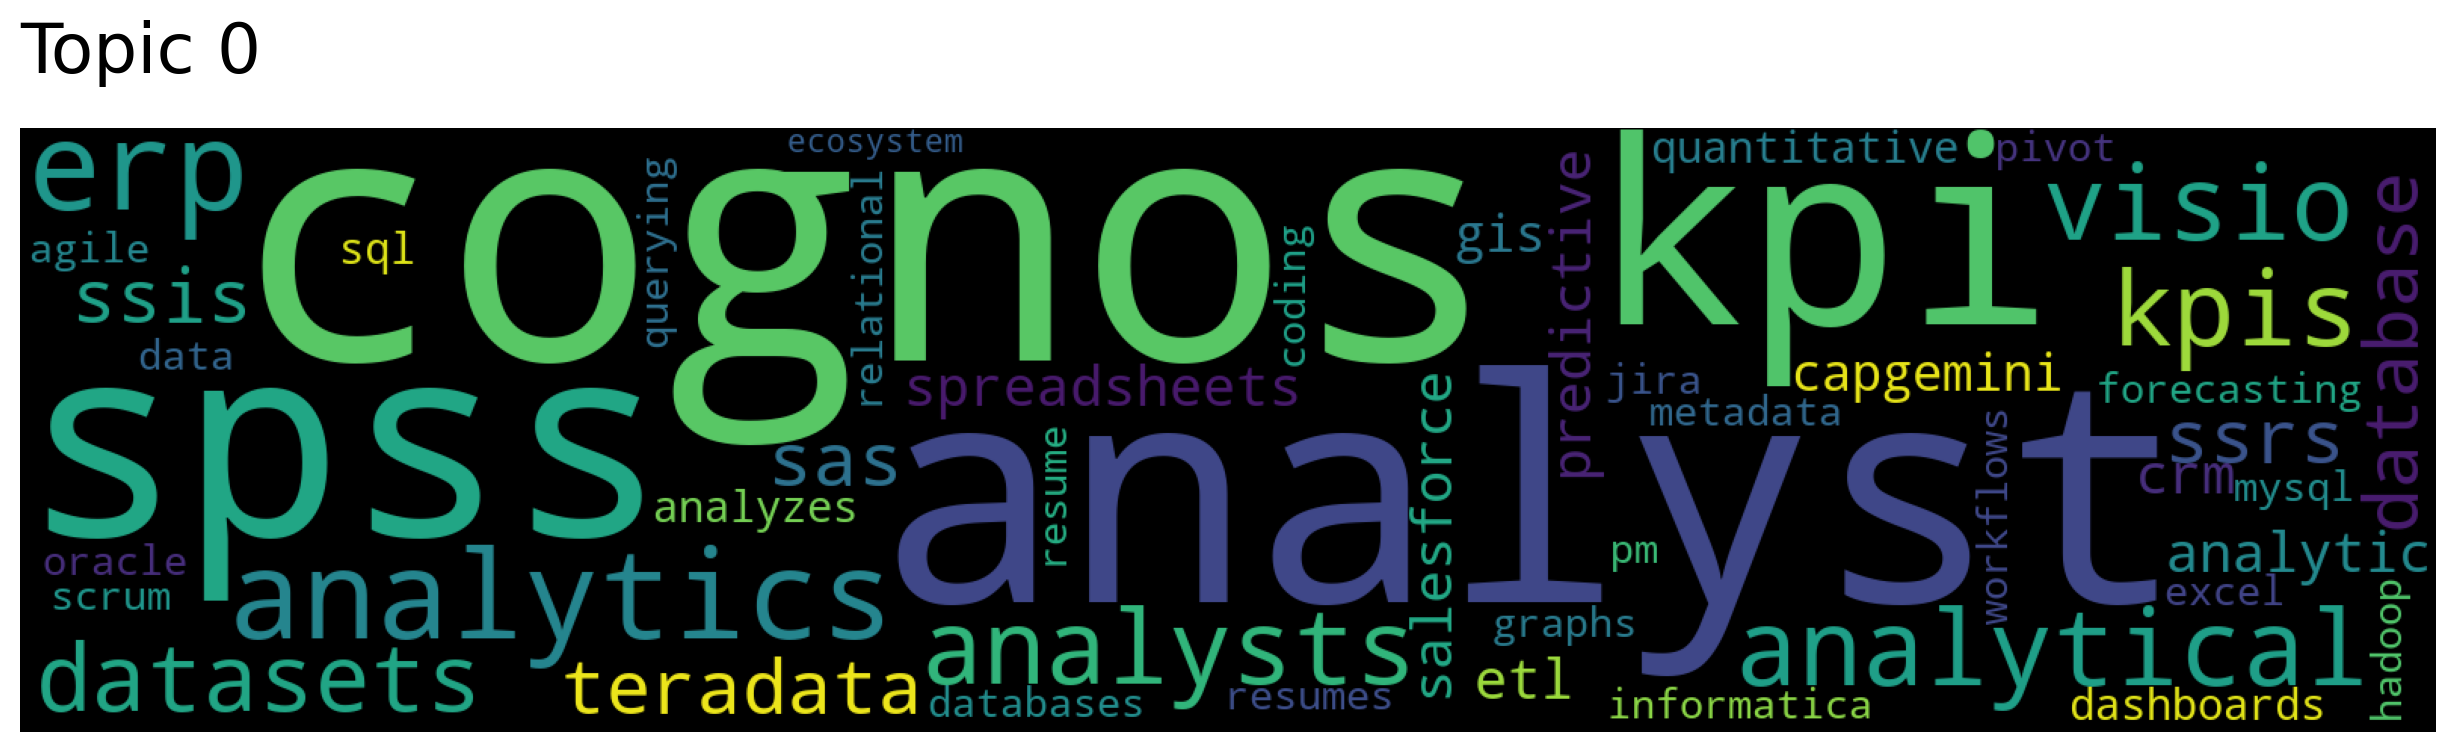

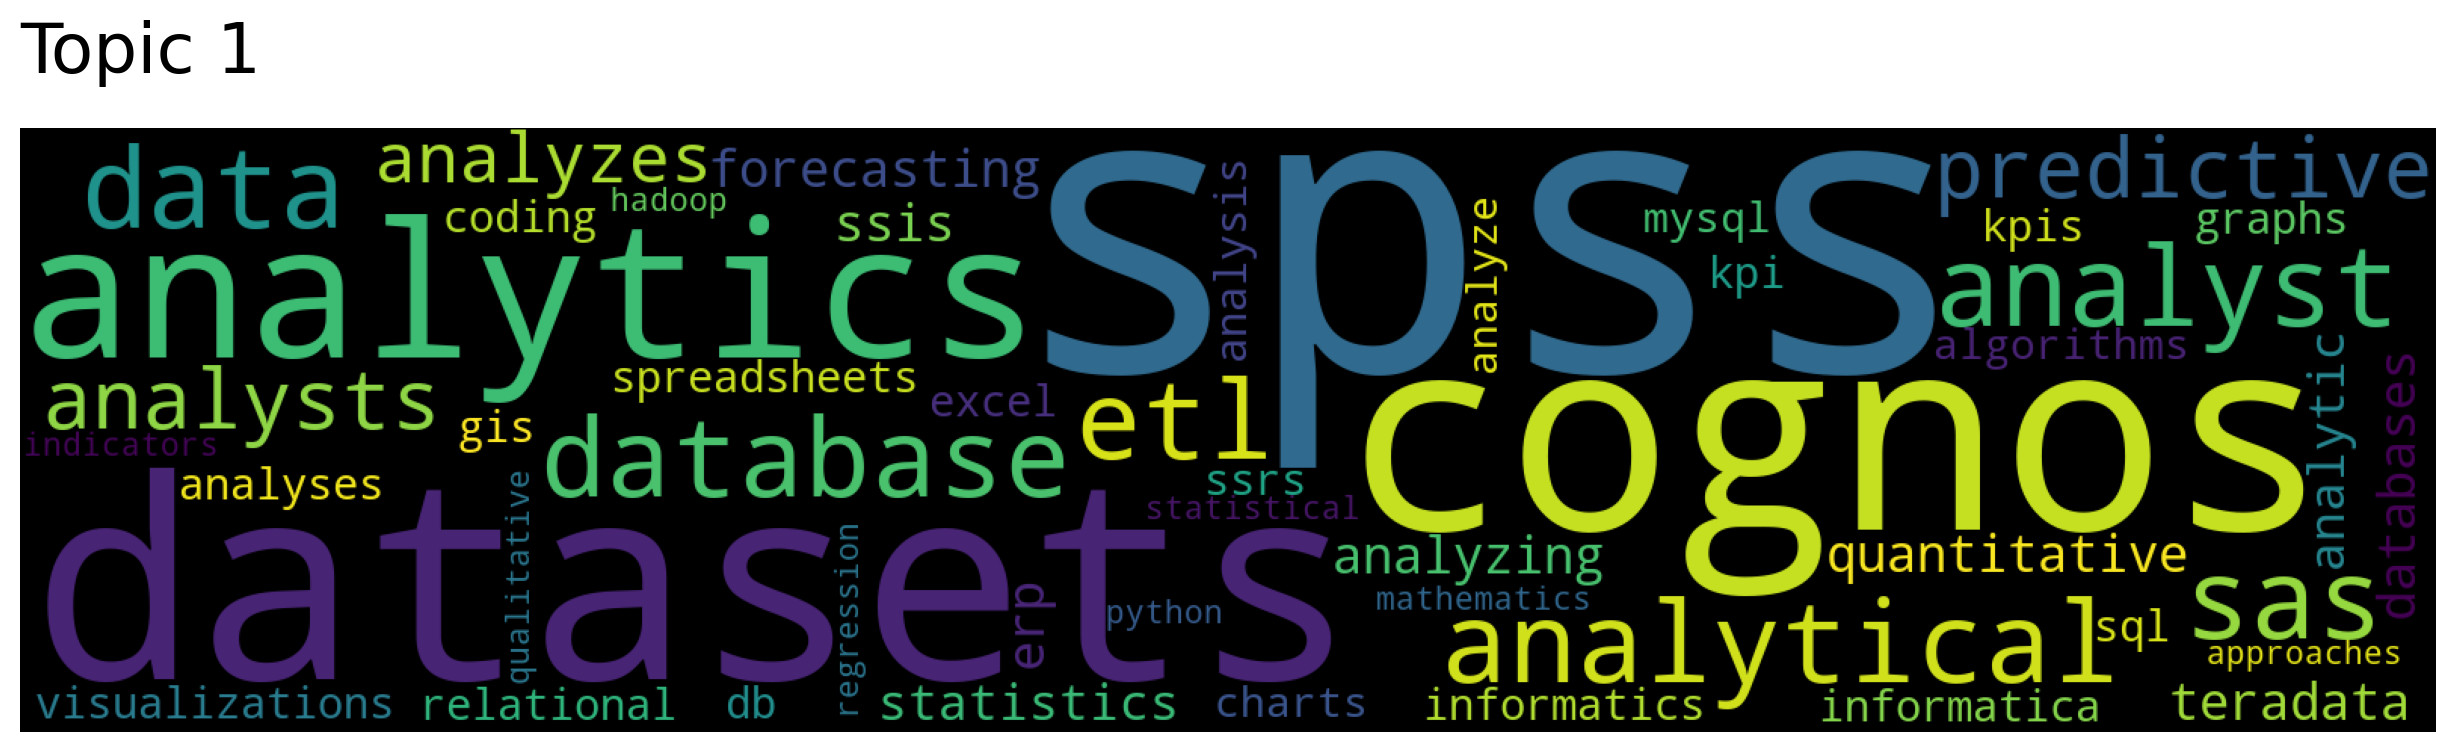

In [ ]:
# plotting word clouds for the top 5 topics
for topic in topic_nums_da_raw:
  top2vec_da_raw.generate_topic_wordcloud(topic)

##### Business Analyst

In [ ]:
ba_raw = list(data[data['JobType'] == 'Business Analyst']['JobDescription'].values)
ba_raw[:5]

["Company Overview   At Memorial Sloan Kettering (MSK), we’re not only changing the way we treat cancer, but also the way the world thinks about it. By working together and pushing forward with innovation and discovery, we’re driving excellence and improving outcomes. For the 28th year, MSK has been named a top hospital for cancer by U.S. News & World Report. We are proud to be on Becker’s Healthcare list as one of the 150 Great Places to Work in Healthcare in 2018, as well as one of Glassdoor’s Employees’ Choice Best Place to Work for 2018. We’re treating cancer, one patient at a time. Join us and make a difference every day.  Job Description   We are excited to recruit two Business Analyst(s) to join our digital, informatics and technology organization who will measure success on our high priority platforms supported by the Division of Health Informatics. DHI focuses on the interaction of people, processes, and technology enabling MSK to meet critical patient care and research object

In [ ]:
# fitting the Top2Vec model using USE embeddings on the raw job description text
# top2vec_ba_raw = Top2Vec(ba_raw, 
#                          speed = 'deep-learn', 
#                          embedding_model = 'universal-sentence-encoder')

# saving raw Top2Vec model
# top2vec_ba_raw.save(root_path + "/data/top2vec_ba_raw")

2021-03-14 21:01:02,894 - top2vec - INFO - Pre-processing documents for training
2021-03-14 21:01:09,639 - top2vec - INFO - Downloading universal-sentence-encoder model
2021-03-14 21:01:27,331 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-03-14 21:01:39,216 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-03-14 21:02:16,142 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-03-14 21:02:16,335 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# loading raw Top2Vec model
top2vec_ba_raw = Top2Vec.load(root_path + "/data/top2vec_ba_raw")

In [ ]:
# getting number of topics
top2vec_ba_raw.get_num_topics()

9

In [ ]:
# getting top 5 topics
topic_words_ba_raw, word_scores_ba_raw, topic_nums_ba_raw = top2vec_ba_raw.get_topics(3)

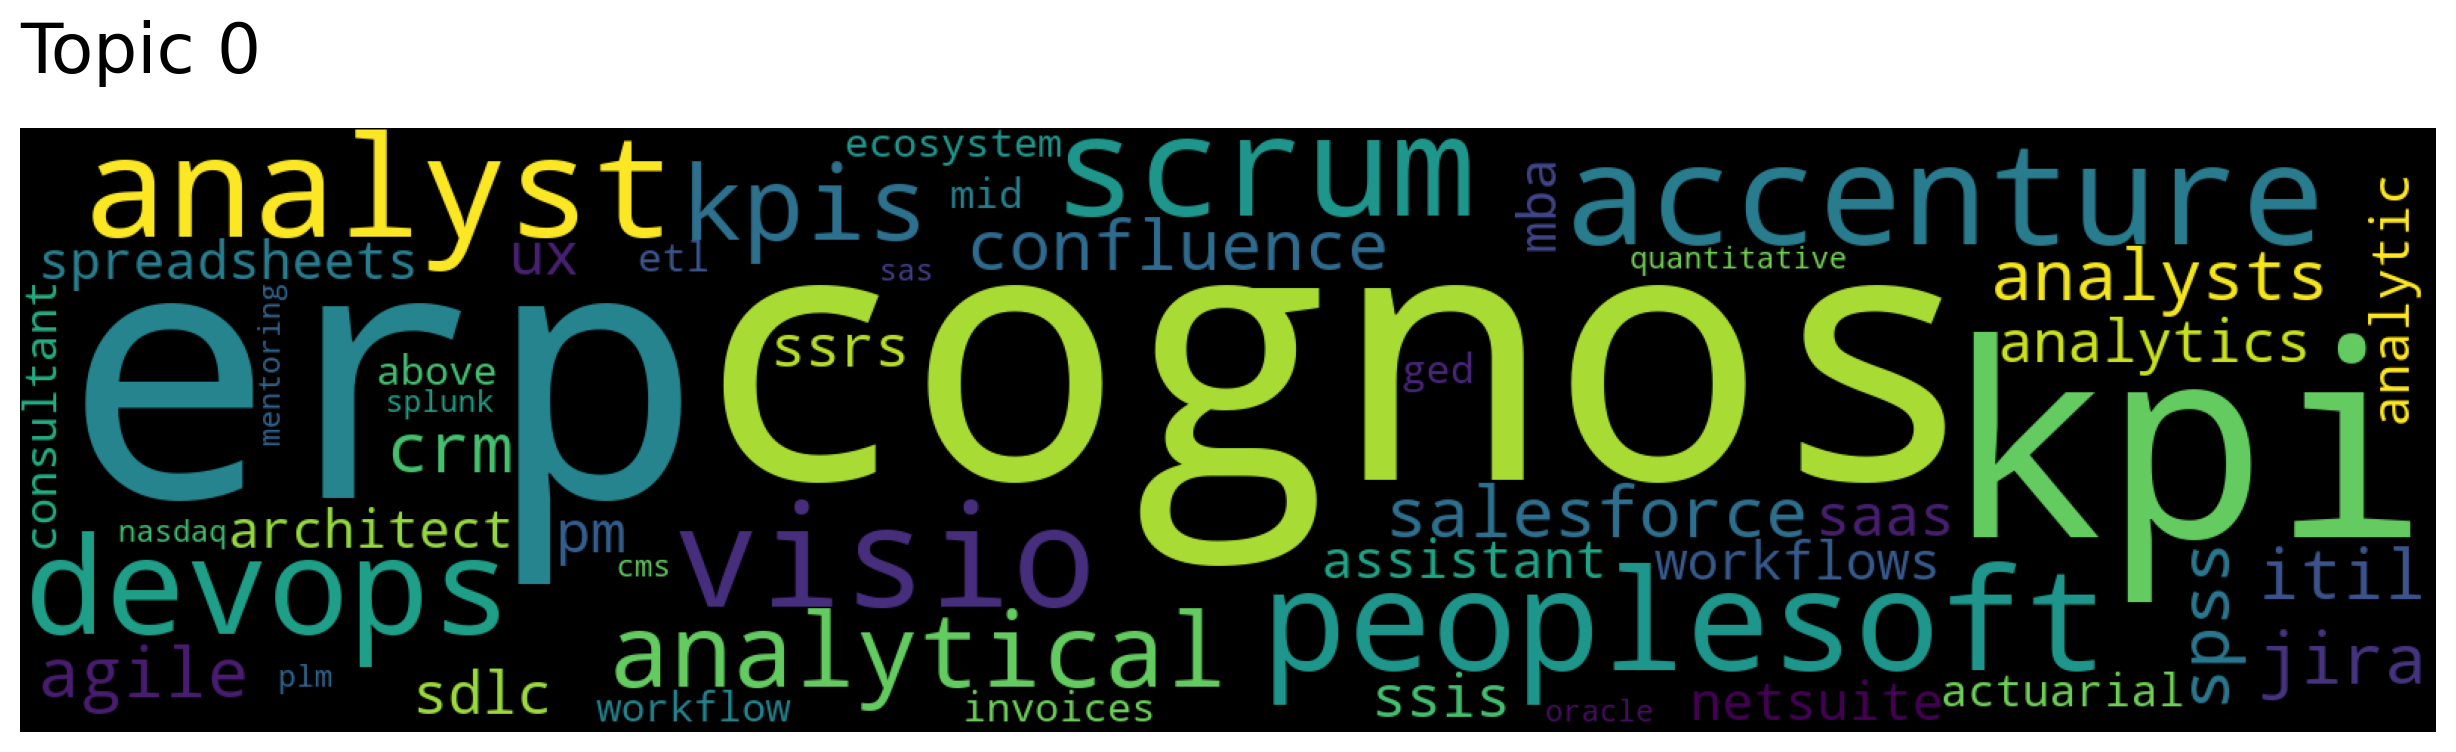

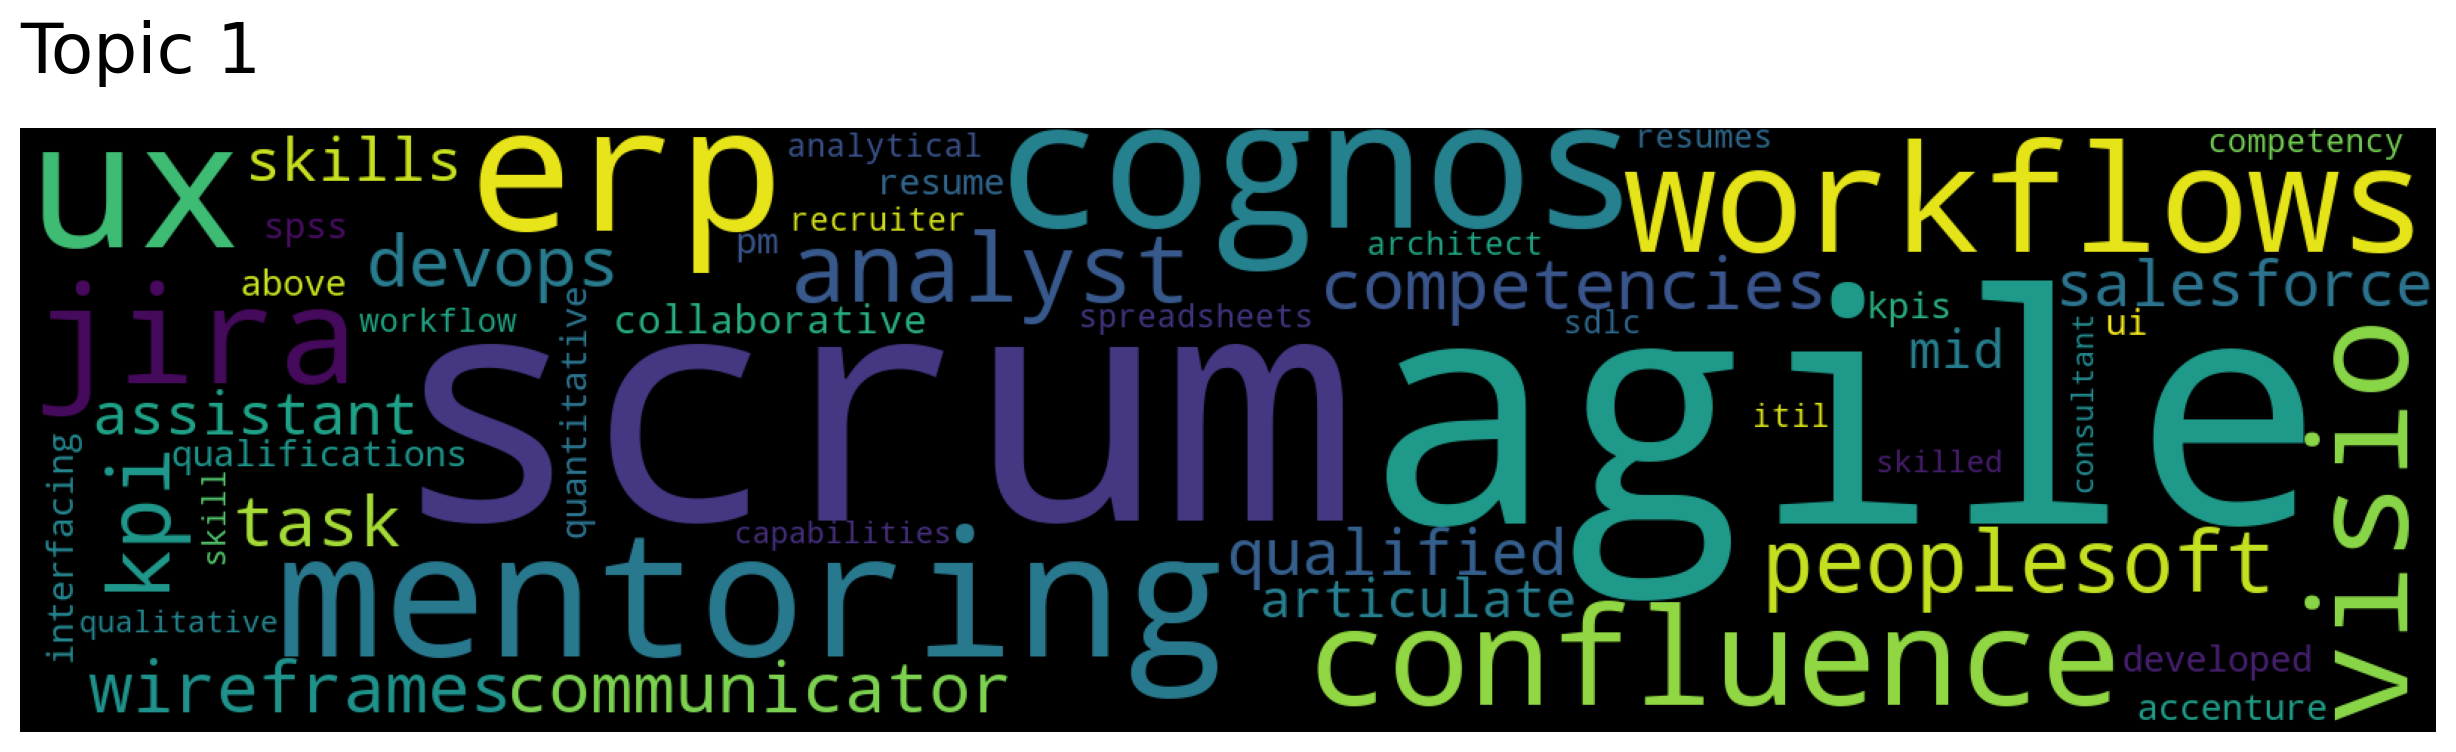

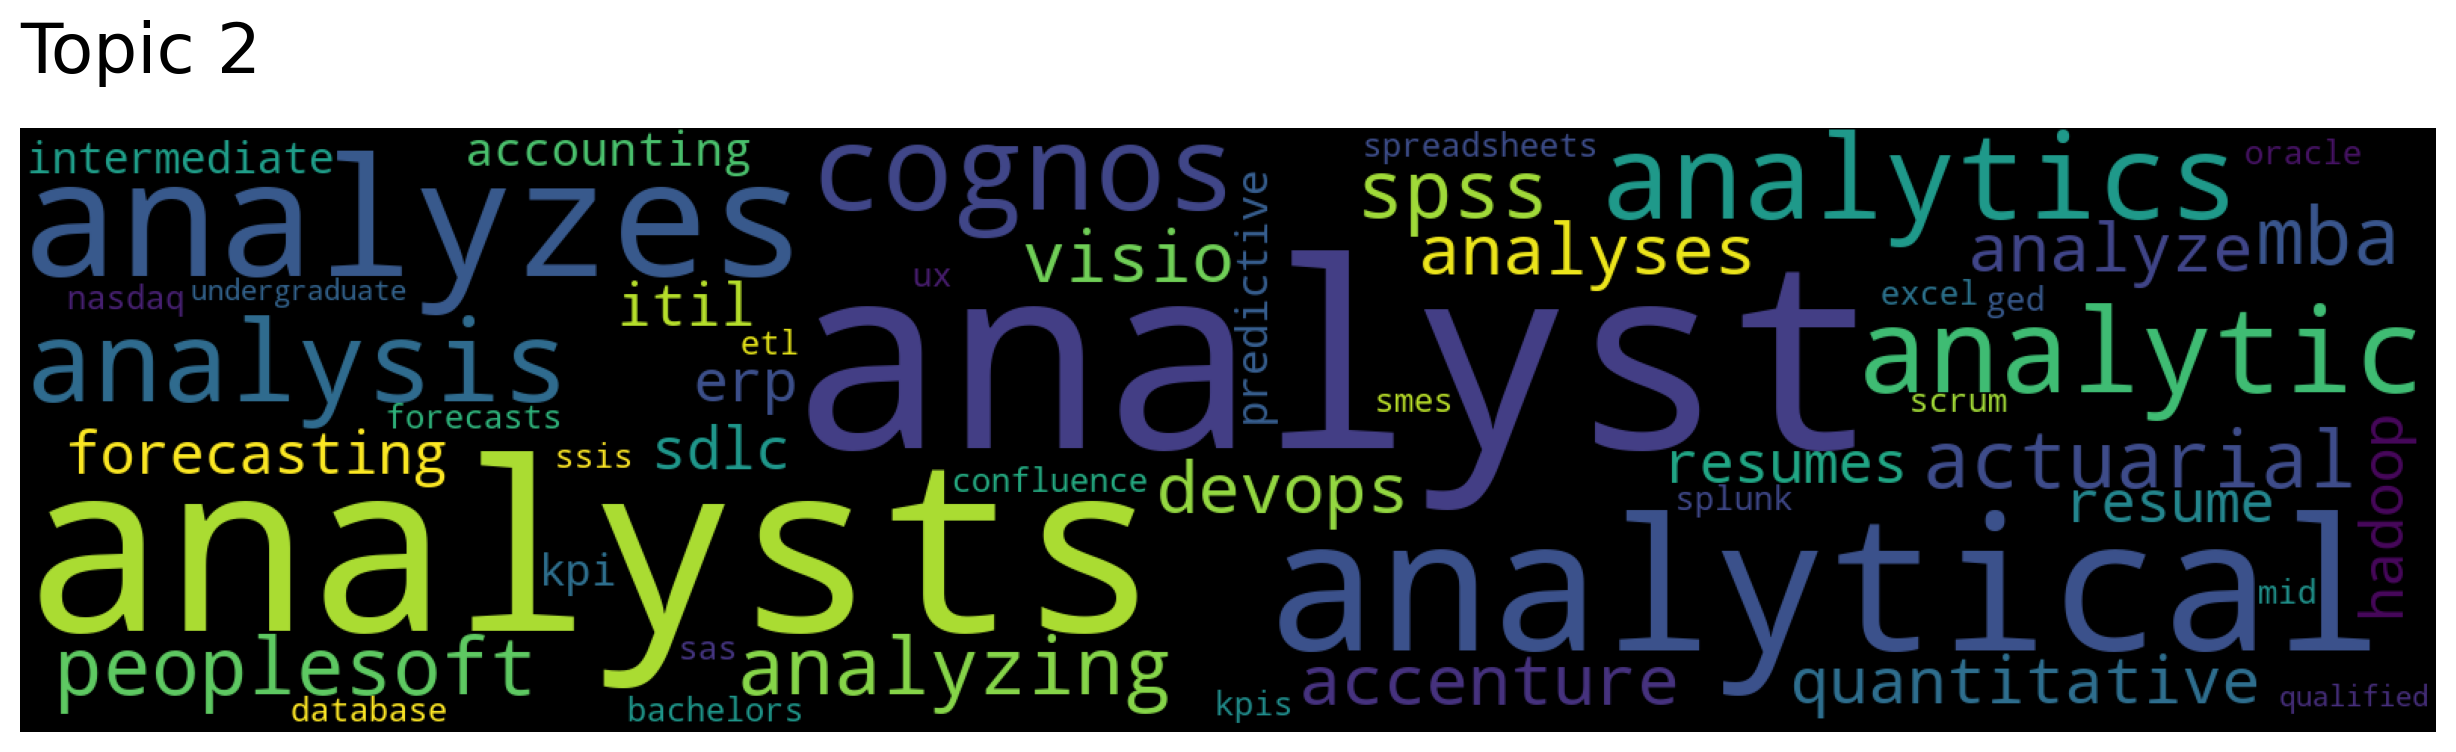

In [ ]:
# plotting word clouds for the top 5 topics
for topic in topic_nums_ba_raw:
  top2vec_ba_raw.generate_topic_wordcloud(topic)

### Job Title - Neural Networks

In [ ]:
# importing TensorFlow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Dropout
from keras.models import Model

In [ ]:
# Define model output visulization
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
# Create copy dataframe for neural network, encoding and splitting data
nn_df = data[['JobTitle','JobDescription','JobType','SalaryAvg']]
X = nn_df.drop('JobType',axis=1)
y = nn_df['JobType']
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
X_train_title, X_test_title, y_train_true, y_test_true = train_test_split(X['JobTitle'].values, encoded_y, test_size = 0.2, random_state = 42)

In [ ]:
# Categorize target variable to be applied in sequential model
y_train = tf.keras.utils.to_categorical(y_train_true, 3)
y_test = tf.keras.utils.to_categorical(y_test_true, 3)

In [ ]:
# Applied GloVe word embeddings 
# We would only focus on limited number of words in GloVe vocabulary and skip some words
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=50)
tokenizer.fit_on_texts(X_train_title)
X_train_title = tokenizer.texts_to_sequences(X_train_title)
X_test_title = tokenizer.texts_to_sequences(X_test_title)

maxlen_title = 50
X_train_title = pad_sequences(X_train_title, padding='post', maxlen=maxlen_title)
X_test_title = pad_sequences(X_test_title, padding='post', maxlen=maxlen_title)

embedding_dim = 100
embedding_matrix_title = create_embedding_matrix('/content/drive/Shareddrives/Data Mining Group Project/data/glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_title, axis=1))
vocab_size_title = len(tokenizer.word_index) + 1
nonzero_elements / vocab_size_title

0.8872979214780601

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size_title, embedding_dim,
                           weights=[embedding_matrix_title], 
                           input_length=maxlen_title, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(25, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           216500    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                2525      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 78        
Total params: 219,103
Trainable params: 219,103
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.8753
Testing Accuracy:  0.8688


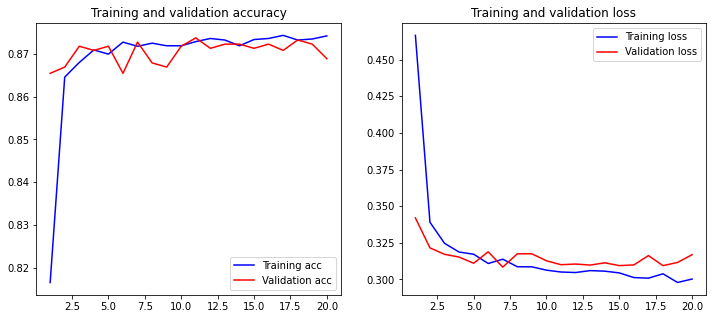

In [ ]:
history = model.fit(X_train_title, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_title, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train_title, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_title, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
# Check Claasification Report for job title
result_train = model.predict(X_train_title)
pr_train = [np.argmax(x) for x in result_train]
result_test = model.predict(X_test_title)
pr_test = [np.argmax(x) for x in result_test]

In [ ]:
print(classification_report(y_train_true, pr_train))
print(classification_report(y_test_true, pr_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3258
           1       0.66      0.98      0.79      1788
           2       0.99      0.79      0.88      3157

    accuracy                           0.88      8203
   macro avg       0.87      0.89      0.87      8203
weighted avg       0.91      0.88      0.88      8203

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       834
           1       0.66      0.98      0.79       465
           2       0.98      0.77      0.86       752

    accuracy                           0.87      2051
   macro avg       0.87      0.88      0.86      2051
weighted avg       0.90      0.87      0.87      2051



### Job Descripiton - Neural Networks

In [ ]:
# With the same random state value, we don't need to create new target variable again
X_train, X_test = train_test_split(X['JobDescription'].values, test_size = 0.2, random_state = 42)

In [ ]:
# Tokenize words based on word values from the dictionary tokenizer.word_index
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# After processing above, we have text sequences that in most cases different length of words. Handle the length issue as below: pad sequence of words with zeros
maxlen = 800
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# Retrieve the embedding matrix
embedding_dim = 100
embedding_matrix = create_embedding_matrix('/content/drive/Shareddrives/Data Mining Group Project/data/glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

In [ ]:
# Check how many embedding vectors are nonzero
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements / vocab_size

0.5916031452136485

In [ ]:
# Initialize sequential model with pretrained weights from GloVe
maxlen = 800
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(25, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 100)          4158700   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

Training Accuracy: 0.8522
Testing Accuracy:  0.7465


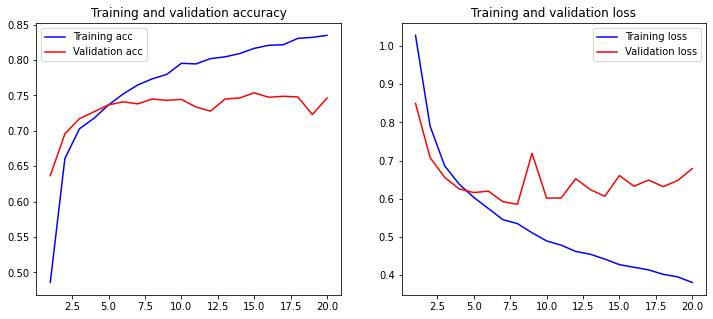

In [ ]:
# Fit the model with epochs as 20 and plot history performance of the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
# Get prediction from the model
result_train = model.predict(X_train)
pr_train = [np.argmax(x) for x in result_train]
result_test = model.predict(X_test)
pr_test = [np.argmax(x) for x in result_test]

In [ ]:
# Check classification results
print(classification_report(y_train_true, pr_train))
print(classification_report(y_test_true, pr_test))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3258
           1       0.61      0.97      0.75      1788
           2       0.97      0.78      0.86      3157

    accuracy                           0.85      8203
   macro avg       0.86      0.87      0.84      8203
weighted avg       0.90      0.85      0.86      8203

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       834
           1       0.51      0.78      0.61       465
           2       0.90      0.72      0.80       752

    accuracy                           0.75      2051
   macro avg       0.75      0.75      0.74      2051
weighted avg       0.79      0.75      0.76      2051



### Job Title + Salary - Neural Networks

In [ ]:
# Define model output visulization for featrue with salary
def plot_history_salary(history):
    acc = history.history['accuracy'][1:]
    val_acc = history.history['val_accuracy'][1:]
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
# With the same random state value, combine SalaryAvg to the model
X_train2, X_test2, = train_test_split(X['SalaryAvg'].values, test_size = 0.2, random_state = 42)

In [ ]:
input_1 = layers.Input(shape=(maxlen_title,))
input_2 = layers.Input(shape=(1,))
embedding_layer = layers.Embedding(vocab_size_title, embedding_dim,
                           weights=[embedding_matrix_title],  
                           trainable=True)(input_1)

globalpool = layers.GlobalMaxPool1D()(embedding_layer)

dense_layer_1 = layers.Dense(5, activation='relu')(input_2)
# dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
concat_layer = layers.Concatenate()([globalpool, dense_layer_1])
dense_layer_3 = layers.Dense(50, activation='relu')(concat_layer)
dropout_1 = layers.Dropout(0.2)(dense_layer_3)
dense_layer_4 = layers.Dense(25, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_layer_4)
output = layers.Dense(3, activation='softmax')(dropout_2)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 100)      216500      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 100)          0           embedding_2[0][0]                
______________________________________________________________________________________________

Training Accuracy: 0.8742
Testing Accuracy:  0.8723


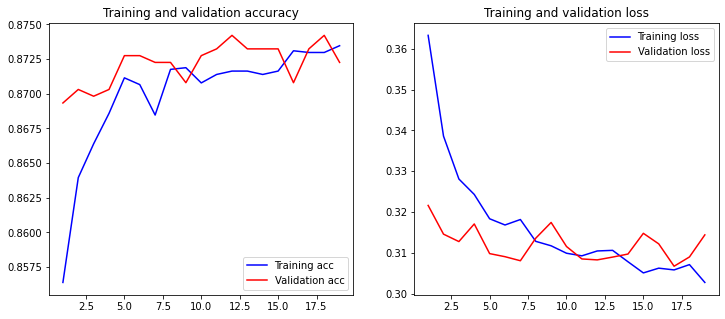

In [ ]:
history = model.fit(x=[X_train_title,X_train2], y=y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=([X_test_title,X_test2], y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x=[X_train_title,X_train2], y=y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x=[X_test_title,X_test2], y=y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history_salary(history)

In [ ]:
result_train = model.predict([X_train_title,X_train2])
pr_train = [np.argmax(x) for x in result_train]
result_test = model.predict([X_test_title,X_test2])
pr_test = [np.argmax(x) for x in result_test]

In [ ]:
print(classification_report(y_train_true, pr_train))
print(classification_report(y_test_true, pr_test))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      3258
           1       0.65      1.00      0.79      1788
           2       1.00      0.78      0.88      3157

    accuracy                           0.87      8203
   macro avg       0.87      0.89      0.87      8203
weighted avg       0.91      0.87      0.88      8203

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       834
           1       0.66      0.99      0.79       465
           2       0.99      0.77      0.87       752

    accuracy                           0.87      2051
   macro avg       0.88      0.89      0.86      2051
weighted avg       0.91      0.87      0.88      2051



### Job Description + Salary - Neural Networks

In [ ]:
input_1 = layers.Input(shape=(maxlen,))
input_2 = layers.Input(shape=(1,))
embedding_layer = layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],  
                           trainable=True)(input_1)

globalpool = layers.GlobalMaxPool1D()(embedding_layer)

dense_layer_1 = layers.Dense(5, activation='relu')(input_2)
# dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
concat_layer = layers.Concatenate()([globalpool, dense_layer_1])
dense_layer_3 = layers.Dense(50, activation='relu')(concat_layer)
dropout_1 = layers.Dropout(0.2)(dense_layer_3)
dense_layer_4 = layers.Dense(25, activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_layer_4)
output = layers.Dense(3, activation='softmax')(dropout_2)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 800)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 800, 100)     4158700     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 100)          0           embedding_3[0][0]                
____________________________________________________________________________________________

Epoch 1/20
821/821 [==============================] - 35s 41ms/step - loss: 1146.9949 - accuracy: 0.3653 - val_loss: 1.0712 - val_accuracy: 0.4066
Epoch 2/20
821/821 [==============================] - 34s 41ms/step - loss: 1.0711 - accuracy: 0.4057 - val_loss: 1.0469 - val_accuracy: 0.6119
Epoch 3/20
821/821 [==============================] - 33s 40ms/step - loss: 1.0127 - accuracy: 0.5179 - val_loss: 0.7803 - val_accuracy: 0.6685
Epoch 4/20
821/821 [==============================] - 33s 40ms/step - loss: 0.7869 - accuracy: 0.6693 - val_loss: 0.6853 - val_accuracy: 0.7216
Epoch 5/20
821/821 [==============================] - 33s 40ms/step - loss: 0.6722 - accuracy: 0.7174 - val_loss: 0.6441 - val_accuracy: 0.7265
Epoch 6/20
821/821 [==============================] - 33s 40ms/step - loss: 0.6532 - accuracy: 0.7233 - val_loss: 0.6324 - val_accuracy: 0.7314
Epoch 7/20
821/821 [==============================] - 33s 40ms/step - loss: 0.6008 - accuracy: 0.7392 - val_loss: 0.5891 - val_accura

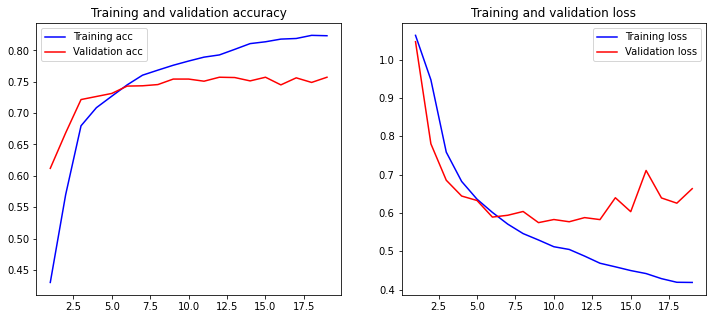

In [ ]:
history = model.fit(x=[X_train,X_train2], y=y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=([X_test,X_test2], y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x=[X_train,X_train2], y=y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x=[X_test,X_test2], y=y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history_salary(history)

In [ ]:
result_train = model.predict([X_train,X_train2])
pr_train = [np.argmax(x) for x in result_train]
result_test = model.predict([X_test,X_test2])
pr_test = [np.argmax(x) for x in result_test]

In [ ]:
print(classification_report(y_train_true, pr_train))
print(classification_report(y_test_true, pr_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3258
           1       0.63      0.91      0.74      1788
           2       0.99      0.76      0.86      3157

    accuracy                           0.85      8203
   macro avg       0.85      0.86      0.84      8203
weighted avg       0.88      0.85      0.86      8203

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       834
           1       0.54      0.68      0.60       465
           2       0.92      0.72      0.81       752

    accuracy                           0.76      2051
   macro avg       0.75      0.74      0.74      2051
weighted avg       0.78      0.76      0.76      2051



### Job Title - Support Vector Machine (SVM)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import TruncatedSVD, NMF, PCA, LatentDirichletAllocation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize, LabelEncoder
from nltk.stem.snowball import SnowballStemmer
import pickle

In [ ]:
# Base - SVM
text_clf_svm = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   random_state=1))])

text_clf_svm = text_clf_svm.fit(X_train['JobTitle'], y_train)
predicted_svm = text_clf_svm.predict(X_test['JobTitle'])
np.mean(predicted_svm == y_test)

# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 
              'tfidf__use_idf': (True, False), 
              'clf__alpha': (1e-2, 1e-3)}

# Similarly doing grid search for SVM
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobTitle'], y_train)
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jt_svm_base.sav', 'wb'))

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.8639516356772343
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# NLTK - SVM
# Removing stop words
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = 'english')), 
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   random_state=1))])

text_clf_svm = text_clf_svm.fit(X_train['JobTitle'], y_train)
predicted_svm = text_clf_svm.predict(X_test['JobTitle'])
np.mean(predicted_svm == y_test)

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobTitle'], y_train)
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jt_svm_stopwords.sav', 'wb'))

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.864439291924912
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# define a class to build a CountVectorizer on a stemmed text using Snowball
# stemmer. this is important to run even though we might be loading the model 
# from disk
class StemmedCountVectorizer(CountVectorizer):
  def build_analyzer(self):
    analyzer = super(StemmedCountVectorizer, self).build_analyzer()
    return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

stemmer = SnowballStemmer("english", ignore_stopwords=True)

In [ ]:
# Stemming Code - SVM
stemmer = SnowballStemmer("english", ignore_stopwords=True)

stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_svm_stemmed = Pipeline([('vect', stemmed_count_vect), 
                             ('tfidf', TfidfTransformer()), 
                             ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   random_state=1))])

text_svm_stemmed = text_svm_stemmed.fit(X_train['JobTitle'], y_train)
predicted_svm_stemmed = text_svm_stemmed.predict(X_test['JobTitle'])
np.mean(predicted_svm_stemmed == y_test)

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_svm_stemmed, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobTitle'], y_train)
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jt_svm_stemmed.sav', 'wb'))

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.863463756484
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# loading models
jt_svm_base = pickle.load(open(root_path + '/data/jt_svm_base.sav', 'rb'))
jt_svm_stopwords = pickle.load(open(root_path + '/data/jt_svm_stopwords.sav', 'rb'))
jt_svm_stemmed = pickle.load(open(root_path + '/data/jt_svm_stemmed.sav', 'rb'))

In [ ]:
# base SVM classification report on the testing data
print(classification_report(y_test, jt_svm_base.predict(X_test['JobTitle'])))
print(confusion_matrix(y_test, jt_svm_base.predict(X_test['JobTitle'])))

                  precision    recall  f1-score   support

Business Analyst       0.97      0.91      0.94       822
    Data Analyst       0.67      0.95      0.79       470
  Data Scientist       0.97      0.78      0.86       759

        accuracy                           0.87      2051
       macro avg       0.87      0.88      0.86      2051
    weighted avg       0.90      0.87      0.88      2051

[[747  71   4]
 [  5 448  17]
 [ 21 145 593]]


In [ ]:
# stemmed SVM classification report on the testing data
print(classification_report(y_test, jt_svm_stemmed.predict(X_test['JobTitle'])))
print(confusion_matrix(y_test, jt_svm_stemmed.predict(X_test['JobTitle'])))

                  precision    recall  f1-score   support

Business Analyst       0.97      0.91      0.94       822
    Data Analyst       0.67      0.95      0.79       470
  Data Scientist       0.96      0.78      0.86       759

        accuracy                           0.87      2051
       macro avg       0.87      0.88      0.86      2051
    weighted avg       0.90      0.87      0.88      2051

[[746  72   4]
 [  5 447  18]
 [ 19 146 594]]


In [ ]:
# removed stopwords SVM classification report on the testing data
print(classification_report(y_test, jt_svm_stopwords.predict(X_test['JobTitle'])))
print(confusion_matrix(y_test, jt_svm_stopwords.predict(X_test['JobTitle'])))

                  precision    recall  f1-score   support

Business Analyst       0.97      0.91      0.94       822
    Data Analyst       0.67      0.95      0.79       470
  Data Scientist       0.97      0.78      0.86       759

        accuracy                           0.87      2051
       macro avg       0.87      0.88      0.86      2051
    weighted avg       0.90      0.87      0.88      2051

[[747  72   3]
 [  5 448  17]
 [ 21 145 593]]


### Job Description - Support Vector Machine (SVM)

In [ ]:
# Base - SVM
# we first define a pipeline that takes as input the raw JobDescription text and
# applies a CountVectorizer, a TF-IDF transformation, and a SVM, sequentially.
text_clf_svm = Pipeline([('vect', CountVectorizer()), 
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss = 'hinge', 
                                                   penalty = 'l2',
                                                   alpha = 1e-3, 
                                                   random_state = 1))])

# the pipeline is fitted on the train data and an untuned accuracy is printed.
text_clf_svm = text_clf_svm.fit(X_train['JobDescription'], y_train)
predicted_svm = text_clf_svm.predict(X_test['JobDescription'])
print(np.mean(predicted_svm == y_test))

# we then define a grid of parameters for the CountVectorizer, TF-IDF, and SVM 
# to perform a grid search for hyperparameter tuning and calculate the best
# results based on the training dataset
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs = -1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobDescription'], y_train)

# we pickle the model to avoid having to run it again
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jd_svm_base.sav', 'wb'))

# these are the best scores and parameters that resulted from the grid search
print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.7191613846903949
0.7252227226111384
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [ ]:
# NLTK - SVM
# Removing stop words. We perform the exact same pipeline, but in this case
# we remove the common english stop words.
text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words = 'english')), 
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3, 
                                                   random_state=1))])

text_clf_svm = text_clf_svm.fit(X_train['JobDescription'], y_train)
predicted_svm = text_clf_svm.predict(X_test['JobDescription'])
print(np.mean(predicted_svm == y_test))

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobDescription'], y_train)
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jd_svm_stopwords.sav', 'wb'))

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.719648951730863
0.7471653215618079
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# Stemming Code - SVM
# in this final model, we remove stopwords and we stem the words to their roots
# using the previously defined class
stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_svm_stemmed = Pipeline([('vect', stemmed_count_vect), 
                             ('tfidf', TfidfTransformer()), 
                             ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3, 
                                                   random_state=1))])

text_svm_stemmed = text_svm_stemmed.fit(X_train['JobDescription'], y_train)
predicted_svm_stemmed = text_svm_stemmed.predict(X_test['JobDescription'])
print(np.mean(predicted_svm_stemmed == y_test))

parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__use_idf': (True, False),
                  'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_svm_stemmed, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(X_train['JobDescription'], y_train)
pickle.dump(gs_clf_svm, 
            open(root_path + '/data/jd_svm_stemmed.sav', 'wb'))

print(gs_clf_svm.best_score_)
print(gs_clf_svm.best_params_)

0.7240370550950755
0.7503344926502281
{'clf-svm__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
# loading models
jd_svm_base = pickle.load(open(root_path + '/data/jd_svm_base.sav', 'rb'))
jd_svm_stopwords = pickle.load(open(root_path + '/data/jd_svm_stopwords.sav', 'rb'))
jd_svm_stemmed = pickle.load(open(root_path + '/data/jd_svm_stemmed.sav', 'rb'))

In [ ]:
# base SVM classification report on the testing data
print(classification_report(y_test, jd_svm_base.predict(X_test['JobDescription'])))
print(confusion_matrix(y_test, jd_svm_base.predict(X_test['JobDescription'])))

                  precision    recall  f1-score   support

Business Analyst       0.73      0.90      0.80       822
    Data Analyst       0.63      0.23      0.33       470
  Data Scientist       0.73      0.83      0.77       759

        accuracy                           0.72      2051
       macro avg       0.69      0.65      0.64      2051
    weighted avg       0.70      0.72      0.69      2051

[[741  23  58]
 [188 107 175]
 [ 91  41 627]]


In [ ]:
# stemmed SVM classification report on the testing data
print(classification_report(y_test, jd_svm_stemmed.predict(X_test['JobDescription'])))
print(confusion_matrix(y_test, jd_svm_stemmed.predict(X_test['JobDescription'])))

                  precision    recall  f1-score   support

Business Analyst       0.76      0.88      0.82       822
    Data Analyst       0.62      0.36      0.46       470
  Data Scientist       0.75      0.82      0.78       759

        accuracy                           0.74      2051
       macro avg       0.71      0.69      0.69      2051
    weighted avg       0.73      0.74      0.72      2051

[[722  41  59]
 [151 171 148]
 [ 75  62 622]]


In [ ]:
# removed stopwords SVM classification report on the testing data
print(classification_report(y_test, jd_svm_stopwords.predict(X_test['JobDescription'])))
print(confusion_matrix(y_test, jd_svm_stopwords.predict(X_test['JobDescription'])))

                  precision    recall  f1-score   support

Business Analyst       0.76      0.88      0.82       822
    Data Analyst       0.62      0.31      0.42       470
  Data Scientist       0.74      0.83      0.78       759

        accuracy                           0.73      2051
       macro avg       0.70      0.68      0.67      2051
    weighted avg       0.72      0.73      0.71      2051

[[726  37  59]
 [156 148 166]
 [ 76  54 629]]
